<h1 style='text-align:center;border:10px double;border-color:gray;'>
    <br/>
     PROJET 6<br/>
    <br/>
    <font color = 'Navy'>"Classifiez automatiquement des biens de consommation"</font>
    <br/>
    <br/>
    
</h1>
<h4 style='text-align:left;border-color:gray;'>
    <br/>
    <font color = 'Navy'>* notebook_pretraitement_feature_extraction_faisaibilite</font>
    <br/>
</h4>

 Dirigé par :   [Pouria Forouzesh](https://www.linkedin.com/in/pouria-forouzesh/)

## Rappel du contexte :

Vous êtes Data Scientist au sein de l’entreprise "Place de marché”, qui souhaite lancer une marketplace e-commerce.


![texte alternatif](pic.png)

Sur la place de marché, des vendeurs proposent des articles à des acheteurs en postant une photo et une description.

Pour l'instant, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs, et est donc peu fiable. De plus, le volume des articles est pour l’instant très petit.

Pour rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne de nouveaux articles) et des acheteurs (faciliter la recherche de produits) la plus fluide possible, et dans l'optique d'un passage à l'échelle, **il devient nécessaire d'automatiser cette tâche.**

Linda, Lead Data Scientist, vous demande donc d'étudier la faisabilité d'un **moteur de classification** des articles en différentes catégories, avec un niveau de précision suffisant.

Ta mission est de réaliser, **dans une première itération, une étude de faisabilité d'un moteur de classification** d'articles, basé sur une image et une description, pour l'automatisation de l'attribution de la catégorie de l'article.

Tu dois **analyser les descriptions textuelles et les images des produits**, au travers des étapes suivantes : 

**Un prétraitement** des données texte ou image suivant le cas ;
Une extraction de features ;
Une **réduction en 2 dimensions**, afin de projeter les produits sur un graphique 2D, sous la forme de points dont la couleur correspondra à la catégorie réelle ;
**Analyse du graphique** afin d’en déduire ou pas, à l’aide des descriptions ou des images, la **faisabilité de regrouper automatiquement** des produits de même catégorie ;
Réalisation d’une **mesure pour confirmer ton analyse visuelle**, en calculant la similarité entre les catégories réelles et les catégories issues d’une segmentation en clusters.
Pourrais-tu nous démontrer, par cette approche, la faisabilité de regrouper automatiquement des produits de même catégorie ?

Voici les contraintes : 

Afin d’extraire les features texte, il sera nécessaire de mettre en œuvre : 
deux approches de type “bag-of-words”, comptage simple de mots et Tf-idataText ;
une approche de type word/sentence embedding classique avec Word2Vec (ou Glove ou FastText) ;
une approche de type word/sentence embedding avec BERT ;
une approche de type word/sentence embedding avec USE (Universal Sentence Encoder). 
En pièce jointe, tu trouveras un **exemple de mise en œuvre de ces approches d’extraction de features texte sur un autre dataset**. Je t’invite à l’utiliser comme point de départ, cela va te faire gagner beaucoup de temps !

Afin d’extraire les features image, il sera nécessaire de mettre en œuvre :
un algorithme de type SIFT / ORB / SURF ;
un algorithme de type CNN Transfer Learning.
Concernant l’approche de type SIFT, je t’invite à regarder le webinaire que nous avons réalisé, disponible dans les ressources.

En pièces jointes, tu trouveras un exemple de mise en œuvre de l’approche de type CNN Transfer Learning d’extraction de features images sur un autre dataset. Je t’invite à l’utiliser comme point de départ, cela va te faire gagner beaucoup de temps !

Maintenant, je te propose de passer à la deuxième itération. Pourrais-tu réaliser une **classification supervisée à partir des images** ? Je souhaiterais que tu mettes en place une **data augmentation** afin d’optimiser le modèle.

En pièce jointe, tu trouveras un exemple de mise en œuvre de classification supervisée sur un autre dataset. Je t’invite à l’utiliser comme point de départ, cela va te faire gagner beaucoup de temps !

Nous souhaitons élargir notre gamme de produits, en particulier dans l’épicerie fine. Pourrais-tu tester la collecte de produits à base de “champagne” via l’API disponible ici ? Je souhaiterais que tu puisses nous fournir une extraction des 10 premiers produits dans un fichier “.csv”, contenant pour chaque produit les données suivantes : foodId, label, category, foodContentsLabel, image.

In [1]:
# !pip install wordcloud

In [2]:
# !pip install nltk

In [3]:
# !pip install fastparquet

In [4]:
# !pip install gensim

In [5]:
# !pip install --upgrade tensorflow_hub

In [6]:
# !pip install tensorflow-text

In [7]:
import pandas as pd
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
import math
import scipy.stats as stats
import nltk
import string
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import zipfile
import os, sys
import requests

from collections import defaultdict
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.font_manager

from sklearn.decomposition import PCA
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score,confusion_matrix,classification_report

from yellowbrick.cluster import SilhouetteVisualizer

import gensim
from gensim.models import Word2Vec

import tensorflow as tf
import tensorflow_text as tf_text

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)
from graphUtils import (
    show_pie,
    show_lines,
    show_pca_variance_graph,
    show_pca_correlation_graph,
    show_scatter_graph,
    show_cols_boxplots_by_col,
    view_clustered_heatmap,
)
pio.renderers.default = "iframe"

import matplotlib.pyplot as plt
import seaborn as sns

working_dir = "working"
if not os.path.isdir(working_dir):
    os.mkdir(working_dir)
    
import tensorflow_hub as hub

In [8]:
from nltk.tokenize import word_tokenize, wordpunct_tokenize, RegexpTokenizer,sent_tokenize


# Chargement des données dans un Dataframe

In [9]:
df = pd.read_csv("flipkart_com-ecommerce_sample_1050.csv")

In [10]:
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [12]:
df.describe(include='all')

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
count,1050,1050,1050,1050,1050,1050,1049.000000,1049.000000,1050,1050,1050,1050,1050,712,1049
unique,1050,149,1050,1050,642,1050,NaN,NaN,1050,2,1050,27,27,490,984
top,55b85ea15a1536d46b7190ad6fff8ce7,2015-12-01 12:40:44 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Bed Linen >> Blankets, Qu...",CRNEG7BKMFFYHQ8Z,NaN,NaN,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,PRINT SHAPES,"{""product_specification""=>[{""key""=>""Type"", ""va..."
freq,1,150,1,1,56,1,NaN,NaN,1,993,1,889,889,11,22
mean,NaN,NaN,NaN,NaN,NaN,NaN,2186.197331,1584.527169,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,7639.229411,7475.099680,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,35.000000,35.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,555.000000,340.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,999.000000,600.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,1999.000000,1199.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: >

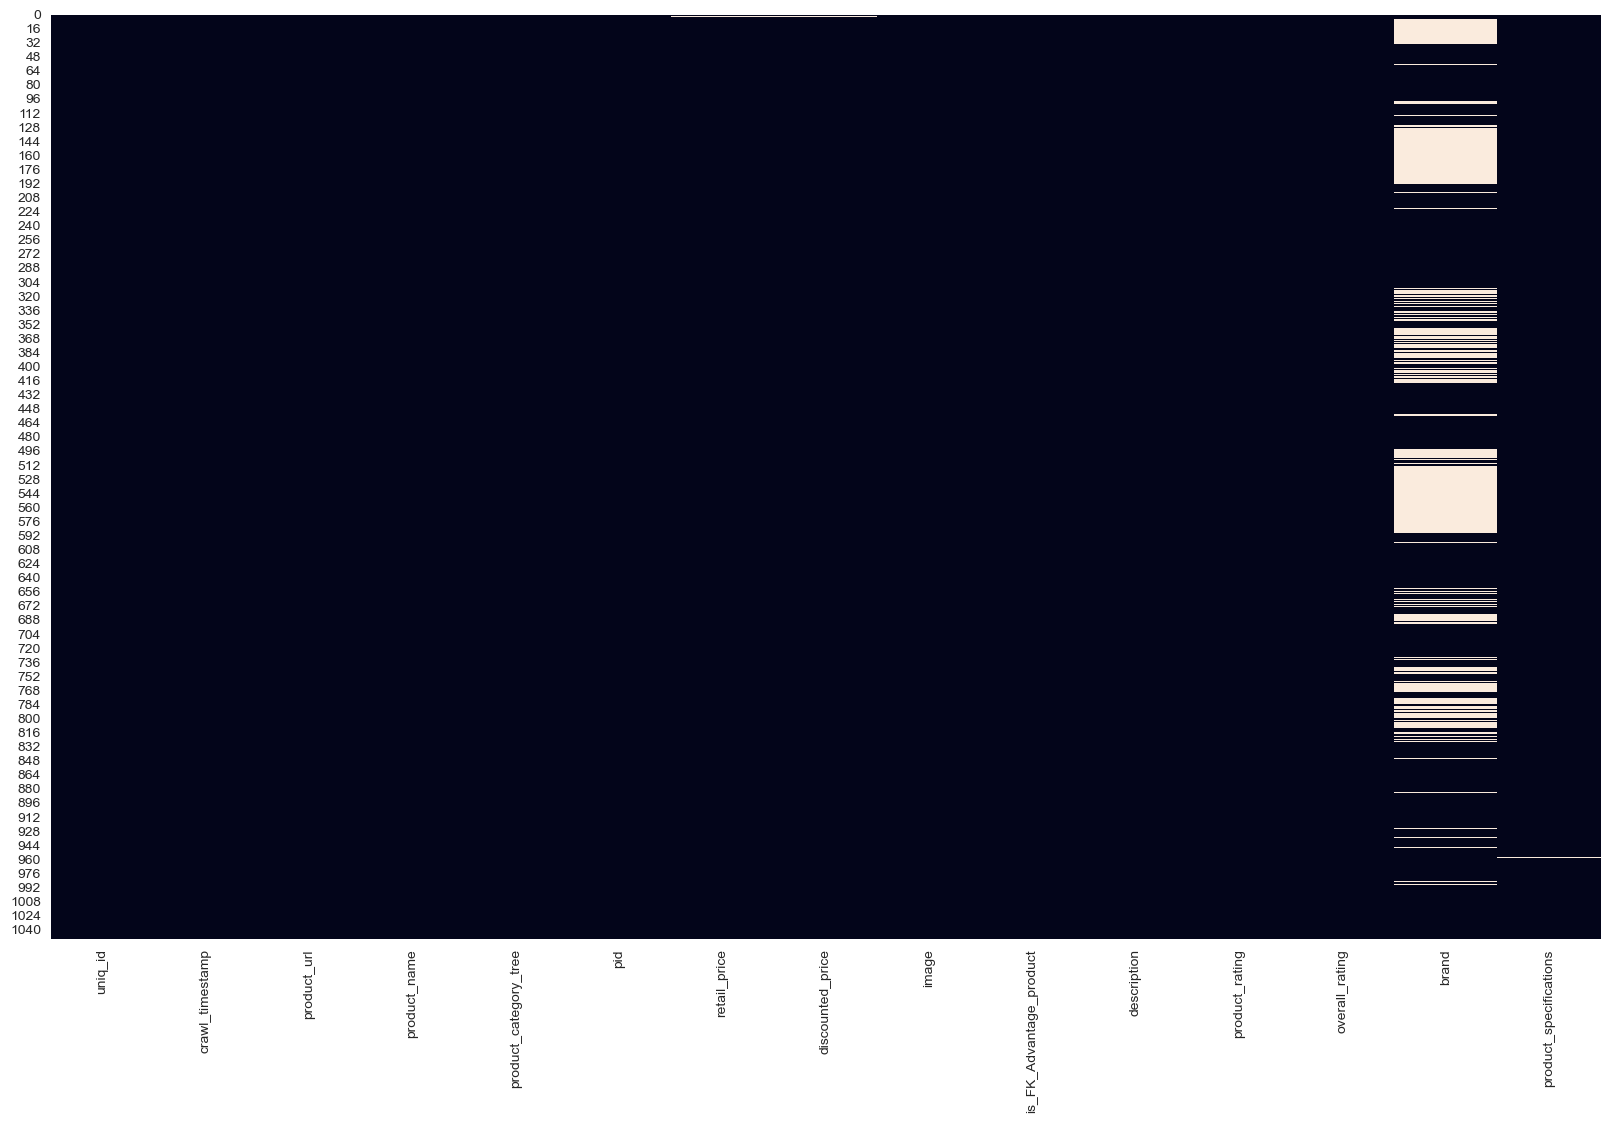

In [13]:
fig, ax = plt.subplots(1,1, figsize=(20,12))
sns.heatmap(df.isna(), cbar=False)

Ici, nous allons travailler sur les features:
- product_name
- description
- product_category_tree

In [14]:
df["product_category_tree"].unique().shape

(642,)

Nous avons 642 catégories pour 1050 produits. Nous allons retenir le 1er niveau.

In [15]:
all_cats = []
for cat in df["product_category_tree"].unique():
    #print(cat)
    cat = cat.strip()[2:-2]
    cat = cat.split(">>")
    #print(cat)
    all_cats.append(cat[0].strip().lower())
    #print(all_cats)
    #1/0
all_cats = set(all_cats)
print(len(all_cats))

7


In [16]:
all_cats

{'baby care',
 'beauty and personal care',
 'computers',
 'home decor & festive needs',
 'home furnishing',
 'kitchen & dining',
 'watches'}

In [17]:
def get_category_level_0(x):
    c = x["product_category_tree"].strip()[2:-2]
    c = c.split(">>")
    return c[0].strip().lower()

df["category0"] = df.apply(lambda x: get_category_level_0(x), axis=1)

In [18]:
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category0
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",home furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",baby care
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",baby care
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",home furnishing
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",home furnishing


<Axes: ylabel='category0'>

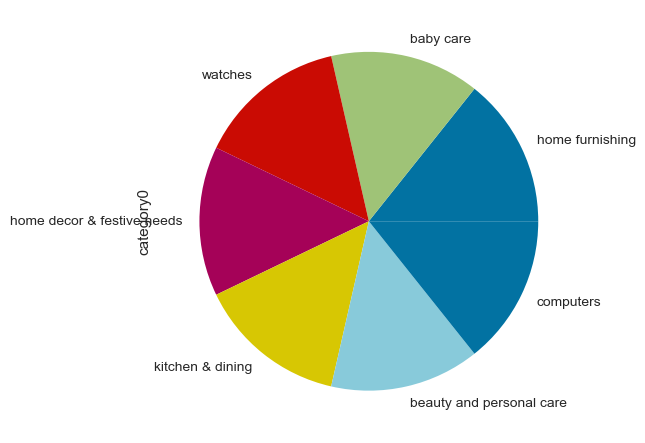

In [19]:
df['category0'].value_counts().plot(kind='pie')

# Analyse du corpus des descriptions

## Description

In [20]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pouri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [21]:
from nltk.stem.snowball import EnglishStemmer
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\pouri\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [22]:
# punkt_folder = "/home/jupyter/nltk_data/tokenizers/punkt"

In [23]:
nltk.download('wordnet')
nltk.download("omw-1.4")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pouri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\pouri\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [24]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pouri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
tokenizer = word_tokenize

In [26]:
stop_words = stopwords.words('english')

In [27]:
# def add_to_corpus(s, corpus=None, tokenizer=None, lemmatizer=None, stemmer=None, stop_words=[]):
#     if tokenizer is None:
#         tokenizer = nltk.data.load(f'{punkt_folder}/english.pickle')
        
#     if corpus is None:
#         corpus = defaultdict(int)
        
#     words = [word.lower() for word in nltk.word_tokenize(s)]
#     for w in words:
#         if lemmatizer is not None:
#             w = lemmatizer.lemmatize(w, "v")
#         if len(w)>3 and w.isalpha() and w.lower() not in stop_words:
#             if stemmer is not None:
#                 w = stemmer.stem(w)
#             if w.lower() not in stop_words:
#                 corpus[w] += 1
        
#     return corpus

#### explication étape par étape de préparation du texte.

In [28]:
df_test = df.copy()
df_test.head(1)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category0
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",home furnishing


In [29]:
df_test['brand'].fillna(value='', inplace=True)

In [30]:
for index, row in df_test.iterrows():
     fullText = row['product_name'] + ' ' + row['description'] + ' ' + row['brand']

In [31]:
print(len(row['product_name']))
print(len(row['description']))
print(len(row['brand']))
print(len(fullText))

28
187
8
225


In [32]:
len(row['product_name']) + len(row['description']) + len(row['brand']) + 2 == len(fullText) # 2 = ' ' + ' '

True

In [33]:
fullText

'Uberlyfe Large Vinyl Sticker Buy Uberlyfe Large Vinyl Sticker for Rs.595 online. Uberlyfe Large Vinyl Sticker at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee. Uberlyfe'

**Regex**

In [34]:
import re

for index, row in df_test.iterrows():
    fullText = row['product_name'] + ' ' + row['description'] + ' ' + row['brand']
    fullText_regex = re.sub('[^a-zA-Z]',' ',fullText) 

In [35]:
fullText_regex

'Uberlyfe Large Vinyl Sticker Buy Uberlyfe Large Vinyl Sticker for Rs     online  Uberlyfe Large Vinyl Sticker at best prices with FREE shipping   cash on delivery  Only Genuine Products     Day Replacement Guarantee  Uberlyfe'

**lower**

In [36]:
for index, row in df_test.iterrows():
    fullText = row['product_name'] + ' ' + row['description'] + ' ' + row['brand']
    fullText_regex = re.sub('[^a-zA-Z]',' ',fullText)
    fullText_regex_lower = fullText_regex.lower()

In [37]:
print('len :', len(fullText_regex_lower))
fullText_regex_lower

len : 225


'uberlyfe large vinyl sticker buy uberlyfe large vinyl sticker for rs     online  uberlyfe large vinyl sticker at best prices with free shipping   cash on delivery  only genuine products     day replacement guarantee  uberlyfe'

**tokenize**

In [38]:
for index, row in df_test.iterrows():
    fullText = row['product_name'] + ' ' + row['description'] + ' ' + row['brand']
    fullText_regex = re.sub('[^a-zA-Z]',' ',fullText)
    fullText_regex_lower = fullText_regex.lower()
    fullText_regex_lower_tokenize = word_tokenize(fullText_regex_lower)

In [39]:
print('len :', len(fullText_regex_lower_tokenize))
print(fullText_regex_lower_tokenize)

len : 32
['uberlyfe', 'large', 'vinyl', 'sticker', 'buy', 'uberlyfe', 'large', 'vinyl', 'sticker', 'for', 'rs', 'online', 'uberlyfe', 'large', 'vinyl', 'sticker', 'at', 'best', 'prices', 'with', 'free', 'shipping', 'cash', 'on', 'delivery', 'only', 'genuine', 'products', 'day', 'replacement', 'guarantee', 'uberlyfe']


**stopwords**

In [40]:
#stopwords
sw = set(stopwords.words('english'))

In [41]:
for index, row in df_test.iterrows():
    fullText = row['product_name'] + ' ' + row['description'] + ' ' + row['brand']
    fullText_regex = re.sub('[^a-zA-Z]',' ',fullText)
    fullText_regex_lower = fullText_regex.lower()
    fullText_regex_lower_tokenize = word_tokenize(fullText_regex_lower)
    fullText_regex_lower_tokenize_stop = [w for w in fullText_regex_lower_tokenize if not w in sw ]

In [42]:
print('len :', len(fullText_regex_lower_tokenize_stop))
print(fullText_regex_lower_tokenize_stop)

len : 27
['uberlyfe', 'large', 'vinyl', 'sticker', 'buy', 'uberlyfe', 'large', 'vinyl', 'sticker', 'rs', 'online', 'uberlyfe', 'large', 'vinyl', 'sticker', 'best', 'prices', 'free', 'shipping', 'cash', 'delivery', 'genuine', 'products', 'day', 'replacement', 'guarantee', 'uberlyfe']


**lemmatizer**

In [43]:
wordnet=WordNetLemmatizer() 

In [44]:
for index, row in df_test.iterrows():
    fullText = row['product_name'] + ' ' + row['description'] + ' ' + row['brand']
    fullText_regex = re.sub('[^a-zA-Z]',' ',fullText)
    fullText_regex_lower = fullText_regex.lower()
    fullText_regex_lower_tokenize = word_tokenize(fullText_regex_lower)
    fullText_regex_lower_tokenize_stop = [w for w in fullText_regex_lower_tokenize if not w in sw ]
    fullText_regex_lower_tokenize_stop_lemm = [wordnet.lemmatize(words) for words in fullText_regex_lower_tokenize_stop ]

In [45]:
print('len :', len(fullText_regex_lower_tokenize_stop_lemm))
print(fullText_regex_lower_tokenize_stop_lemm)

len : 27
['uberlyfe', 'large', 'vinyl', 'sticker', 'buy', 'uberlyfe', 'large', 'vinyl', 'sticker', 'r', 'online', 'uberlyfe', 'large', 'vinyl', 'sticker', 'best', 'price', 'free', 'shipping', 'cash', 'delivery', 'genuine', 'product', 'day', 'replacement', 'guarantee', 'uberlyfe']


In [46]:
import nltk
from nltk.tokenize import word_tokenize
from collections import defaultdict

def add_to_corpus(s, corpus=None, tokenizer=None, lemmatizer=None, stemmer=None, stop_words=[]):
    if tokenizer is None:
        tokenizer = word_tokenize
        
    if corpus is None:
        corpus = defaultdict(int)
        
    words = [word.lower() for word in tokenizer(s)]
    for w in words:
        if lemmatizer is not None:
            w = lemmatizer.lemmatize(w, "v")
        if len(w) > 3 and w.isalpha() and w.lower() not in stop_words:
            if stemmer is not None:
                w = stemmer.stem(w)
            if w.lower() not in stop_words:
                corpus[w] += 1
        
    return corpus


In [47]:
corpus_description = None
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

for desc in df["description"]:
    corpus_description = add_to_corpus(desc, corpus=corpus_description, tokenizer=tokenizer, lemmatizer=lemmatizer, stemmer=stemmer, stop_words=stop_words)

In [48]:
nb_shown = 0
for index, (key, value) in enumerate(dict(sorted(corpus_description.items(), key=lambda item: item[1], reverse=True)).items()):
    print(f"{key}: {value}")
    nb_shown += 1
    if nb_shown>100:
        break

product: 868
free: 613
replac: 570
ship: 569
deliveri: 567
genuin: 564
cash: 564
price: 558
guarante: 473
featur: 408
onlin: 396
design: 395
specif: 379
color: 369
watch: 360
pack: 341
make: 338
type: 324
babi: 321
materi: 310
cotton: 296
gener: 292
print: 290
packag: 275
sale: 262
analog: 255
number: 250
warranti: 249
brand: 247
detail: 246
qualiti: 243
girl: 242
laptop: 234
best: 230
inch: 227
model: 220
gift: 220
ceram: 217
fabric: 210
showpiec: 207
cover: 205
size: 196
perfect: 190
great: 189
india: 180
dimens: 175
skin: 170
home: 169
ideal: 167
multicolor: 160
content: 157
light: 154
beauti: 152
combo: 148
power: 144
water: 142
women: 139
discount: 134
love: 134
adapt: 131
width: 129
give: 128
black: 127
also: 126
batteri: 125
comfort: 124
care: 122
wash: 122
pattern: 118
coffe: 116
style: 115
height: 114
blue: 113
high: 110
look: 109
shape: 109
name: 107
length: 107
towel: 106
dress: 105
come: 104
round: 104
weight: 102
easi: 102
wall: 102
bodi: 101
decor: 101
craft: 98
addit: 96

In [49]:
len(corpus_description)

3436

On voit certains mots qui ont des fréquences très élevées mais qui n'ont pas d'interet, exemples: product, free, discount

Nous allons ajouter ces mots au tableau stop_words

In [50]:
stop_words2 = []
for index, (key, value) in enumerate(corpus_description.items()):
    if value>=243 and key!="cotton" and key!="babi" and key!="watch" and key!="analog":
        stop_words2.append(key)
stop_words2 += ["also", "look", "make", "use", "height", "width", "size", "brand", "inch", "model", "name", "discount", "perfect", "made", "gift", "ideal", "code"]


In [51]:
stop_words2

['featur',
 'pack',
 'price',
 'make',
 'qualiti',
 'design',
 'print',
 'specif',
 'gener',
 'brand',
 'type',
 'color',
 'number',
 'sale',
 'packag',
 'materi',
 'product',
 'warranti',
 'onlin',
 'genuin',
 'replac',
 'guarante',
 'free',
 'ship',
 'cash',
 'deliveri',
 'detail',
 'also',
 'look',
 'make',
 'use',
 'height',
 'width',
 'size',
 'brand',
 'inch',
 'model',
 'name',
 'discount',
 'perfect',
 'made',
 'gift',
 'ideal',
 'code']

In [52]:
corpus_description = None
stop_words2 = stop_words+stop_words2
for desc in df["description"]:
    corpus_description = add_to_corpus(desc, corpus=corpus_description, tokenizer=tokenizer, lemmatizer=lemmatizer, stemmer=stemmer, stop_words=stop_words2)

In [53]:
nb_words = []
txt_words = []
for index, (key, value) in enumerate(dict(sorted(corpus_description.items(), key=lambda item: item[1], reverse=True)).items()):
    if index<=20:
        print(f"{key}: {value}")
    nb_words.append(value)
    txt_words.append(key)

watch: 360
babi: 321
cotton: 296
analog: 255
girl: 242
laptop: 234
best: 230
ceram: 217
fabric: 210
showpiec: 207
cover: 205
great: 189
india: 180
dimens: 175
skin: 170
home: 169
multicolor: 160
content: 157
light: 154
beauti: 152
combo: 148


In [54]:
fig = go.Figure(data=go.Scatter(x=list(range(0, len(nb_words))),
                                y=nb_words,
                                mode='markers',
                                text=txt_words)) # hover text goes here

fig.update_layout(title='Mots utilisés dans les descriptions')
fig.show()

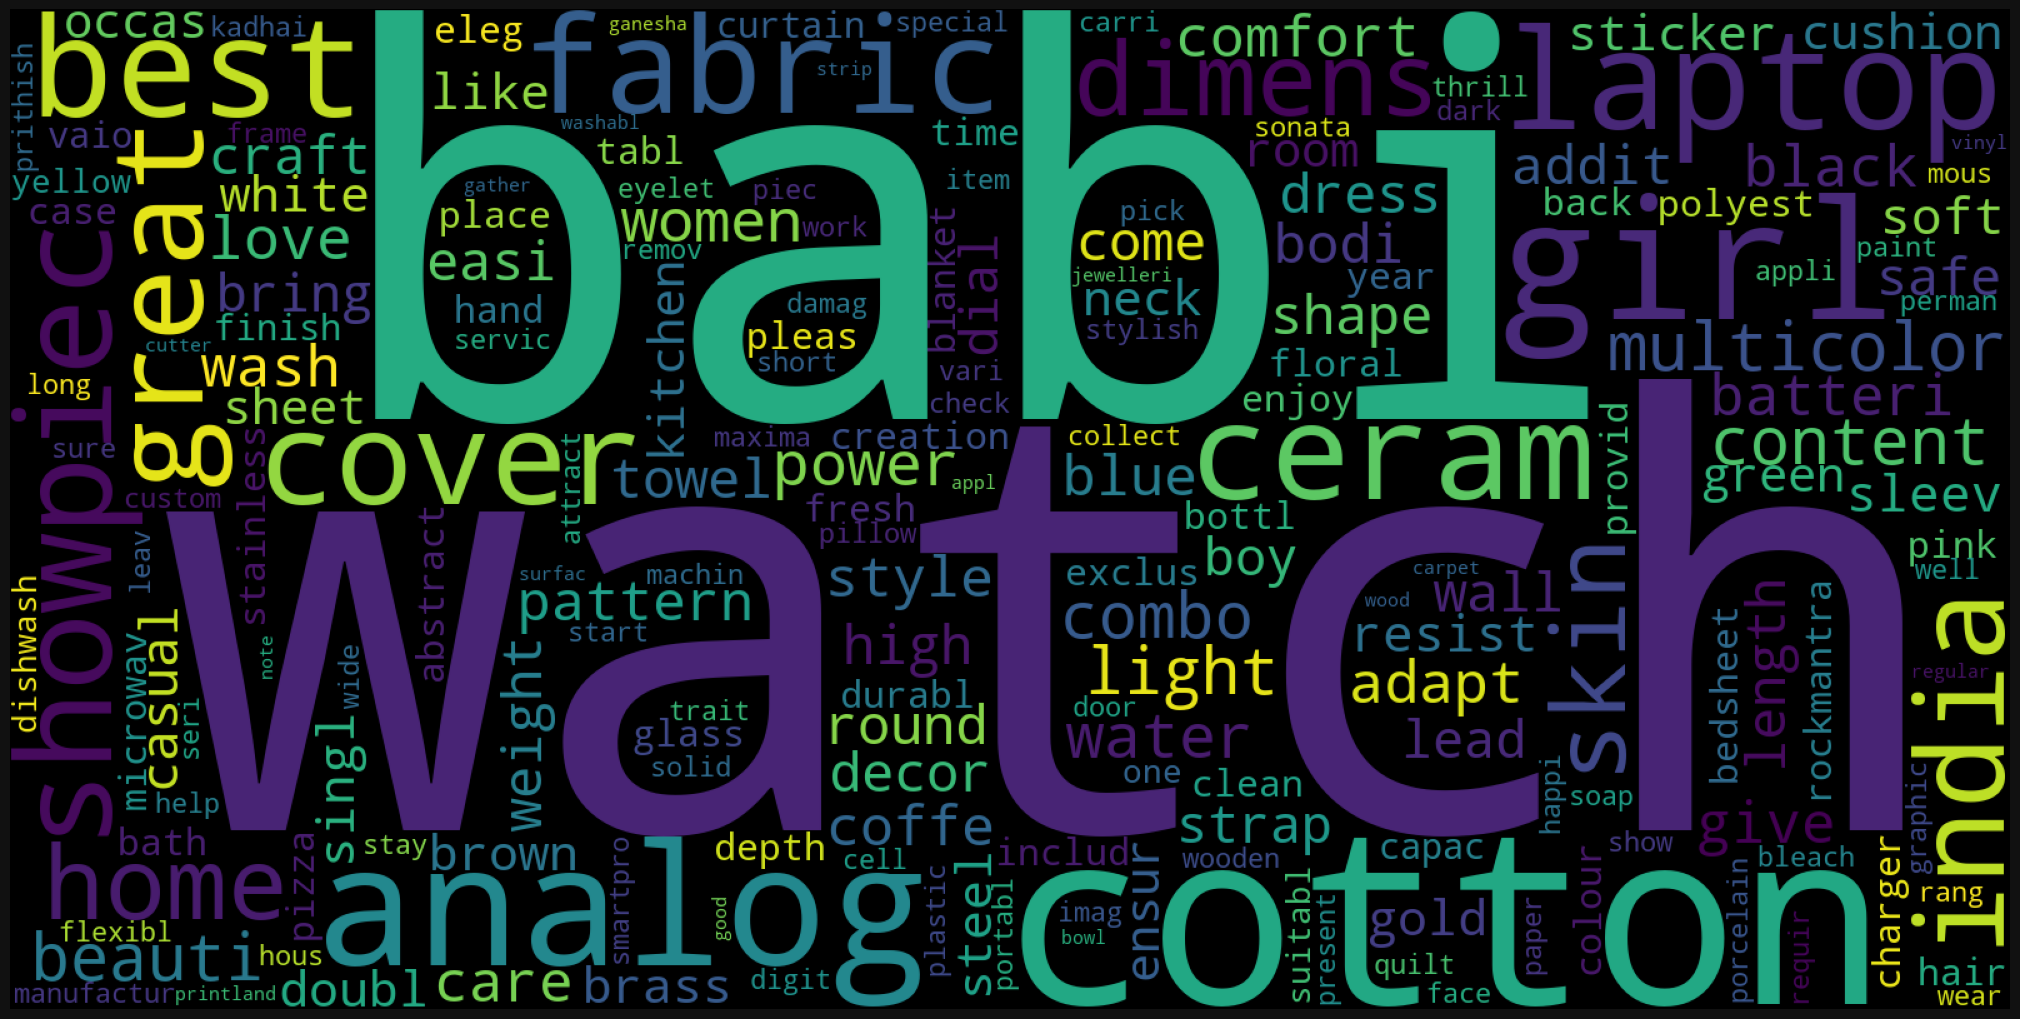

In [55]:
wordcloud = WordCloud(width=1600, height=800).generate_from_frequencies(corpus_description)
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()



## product_name

In [56]:
corpus_title = None
for desc in df["product_name"]:
    corpus_title = add_to_corpus(desc, corpus=corpus_title, tokenizer=tokenizer, lemmatizer=lemmatizer, stemmer=stemmer, stop_words=stop_words2)

In [57]:
nb_words = []
txt_words = []
for index, (key, value) in enumerate(dict(sorted(corpus_title.items(), key=lambda item: item[1], reverse=True)).items()):
    if index<=20:
        print(f"{key}: {value}")
    nb_words.append(value)
    txt_words.append(key)

watch: 151
analog: 127
showpiec: 105
babi: 94
combo: 93
ceram: 78
girl: 71
cotton: 55
women: 55
singl: 45
doubl: 40
abstract: 39
laptop: 39
boy: 35
light: 33
blue: 32
towel: 31
lead: 31
multicolor: 29
comfort: 29
floral: 27


In [58]:
fig = go.Figure(data=go.Scatter(x=list(range(0, len(nb_words))),
                                y=nb_words,
                                mode='markers',
                                text=txt_words)) # hover text goes here

fig.update_layout(title='Mots utilisés dans les noms de produits')
fig.show()

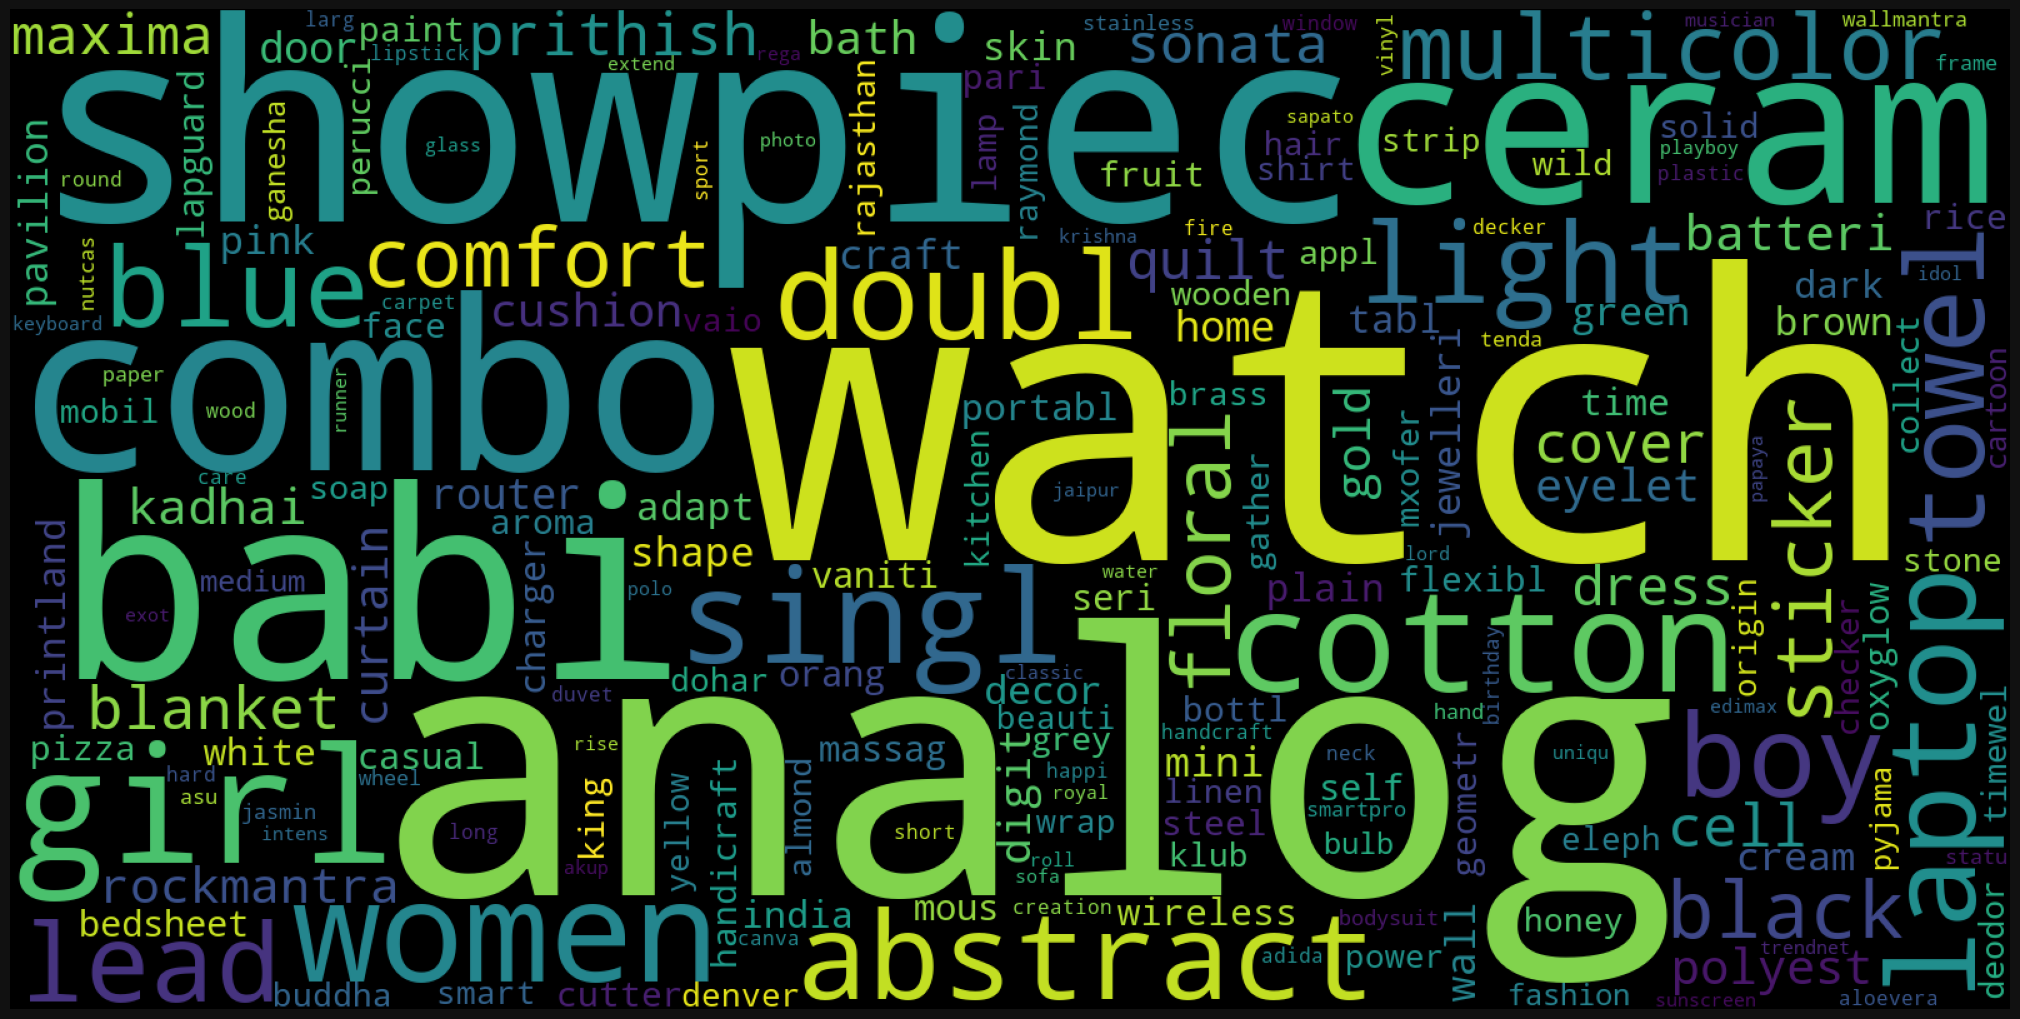

In [59]:
wordcloud = WordCloud(width=1600, height=800).generate_from_frequencies(corpus_title)
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

# Nettoyage des corpus

On constate que la marque du produit peut se retrouver dans product_name ou description.

In [60]:
def clean_text(x, col, tokenizer=None, lemmatizer=None, stemmer=None, stop_words=[]):
    s = x[col].lower()
    if not pd.isna(x["brand"]):
        s = s.replace(x["brand"].lower(), "")
    
    if tokenizer is None:
        tokenizer = word_tokenize
                
    r = []
    words = [word.lower() for word in nltk.word_tokenize(s)]
    for w in words:
        if lemmatizer is not None:
            w = lemmatizer.lemmatize(w)
        if len(w)>3 and w.isalpha() and w.lower() not in stop_words:
            if stemmer is not None:
                w = stemmer.stem(w)
            if w.lower() not in stop_words:
                r.append(w)
    return " ".join(r)

df["cleaned_product_name"] = df.apply(lambda x: clean_text(x, "product_name", tokenizer, lemmatizer, stemmer, stop_words2), axis=1)

In [61]:
# df.head()

In [62]:
df.loc[:, ["product_name", "cleaned_product_name"]].tail(20)

,product_name,cleaned_product_name
1030,OMRD RD6697 Hot and cold Pack,cold
1031,Kerastase Nutritive Bain Satin 1 Complete Nutr...,nutrit bain satin complet nutrit shampoo
1032,PRINT SHAPES mary and max cartoon Laptop Skin ...,mari cartoon laptop skin mous combo
1033,Aroma Comfort Polyester Dark Blue Plain Eyelet...,polyest dark blue plain eyelet window curtain
1034,PRINT SHAPES Peacock Feather Laptop Skin with ...,peacock feather laptop skin mous combo
1035,PRINT SHAPES despicable me 2 looking upwards L...,despic upward laptop skin mous combo
1036,PRINT SHAPES Red bull Laptop Skin with Mouse p...,bull laptop skin mous combo
1037,Aroma Comfort Polyester Brown Self Design Eyel...,polyest brown self eyelet door curtain
1038,"Surgical e Sstudio S0004 Gown, Pant Hospital S...",gown pant hospit scrub
1039,Reiki Crystal Products Showpiece - 6 cm,showpiec


## description

In [63]:
df["cleaned_description"] = df.apply(lambda x: clean_text(x, "description", tokenizer, lemmatizer, stemmer, stop_words2), axis=1)

In [64]:
df.loc[:, ["description", "cleaned_description"]]

,description,cleaned_description
0,Key Features of Elegance Polyester Multicolor ...,polyest multicolor abstract eyelet door curtai...
1,Specifications of Sathiyas Cotton Bath Towel (...,cotton bath towel bath towel yellow blue bath ...
2,Key Features of Eurospa Cotton Terry Face Towe...,cotton terri face towel small cotton terri fac...
3,Key Features of SANTOSH ROYAL FASHION Cotton P...,cotton king doubl bedsheet royal bedsheet perf...
4,Key Features of Jaipur Print Cotton Floral Kin...,cotton floral king doubl bedsheet cotton cotto...
...,...,...
1045,Oren Empower Extra Large Self Adhesive Sticker...,extra larg self adhes sticker doubl sticker wa...
1046,Wallmantra Large Vinyl Sticker Sticker (Pack o...,larg vinyl sticker sticker bring home exclus p...
1047,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,extra larg pigment polyvinyl film import stick...
1048,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,medium vinyl sticker sticker medium vinyl stic...


In [65]:
# df.to_csv('df_clean.csv',  index=False)

## Enregistrement

In [66]:
df_experiments = pd.DataFrame({
    'algorithm': pd.Series(dtype='str'),
    'used_text': pd.Series(dtype='str'),
    'projection': pd.Series(dtype='str'),
    'silhouette': pd.Series(dtype='float')
})

In [67]:
def log_experiment(df_experiments, algo, used_text, projection, XX, ref_category):
    score = silhouette_score(XX, ref_category)
    df_experiments = pd.concat(
        [
            df_experiments,
            pd.DataFrame(
                [{
                    "algorithm": algo,
                    "used_text": used_text,
                    "projection": projection,
                    "silhouette": score,
                }]
            )
        ],
        ignore_index=True,
    )
    print(f"Silhouette score = {score}")
    return df_experiments

# Création d'un bag of words avec CountVectorizer

## Expérience 1
Ici, nous concaténons cleaned_product_name et cleaned_description et faisons une décomposition sur cette nouvelle colonne (fit et transform)

In [68]:
df["cleaned_text"] = df["cleaned_product_name"].astype(str) + " " + df["cleaned_description"].astype(str)

In [69]:
vectorizer_product_name_description= CountVectorizer()
X = vectorizer_product_name_description.fit_transform(df["cleaned_text"]).toarray()

In [70]:
vectorizer_product_name_description.get_feature_names_out()

array(['aari', 'abil', 'abl', ..., 'zone', 'zoom', 'zora'], dtype=object)

In [71]:
X.shape

(1050, 3076)

In [72]:
scaler = MinMaxScaler()
#X = scaler.fit_transform(df.loc[:, num_cols])
X = scaler.fit_transform(X)

In [73]:
algo="CountVectorizer"

In [74]:
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name + cleaned_description", "None", X, df["category0"])

Silhouette score = -0.0712346439628637


### Projection PCA

In [75]:
pca = PCA(n_components=1000)
pca.fit(X)

PCA(n_components=1000)

In [76]:
show_pca_variance_graph(pca)

Nous allons garder les 623 premières composantes de la PCA, ce qui représente une variance totale à 99% de la variance totale

In [77]:
pca = PCA(n_components=623)

pca.fit(X)
X_pca = pca.transform(X)
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name + cleaned_description", "PCA - 623", X_pca, df["category0"])

Silhouette score = -0.07197191206792032


In [78]:
show_scatter_graph(
    x=X_pca[:,0],
    y=X_pca[:,1],
    colors=df["category0"],
    title="Projection PCA sur les 2 premiers axes",
)

In [79]:
# show_scatter_graph(
#     x=X_pca[:,2],
#     y=X_pca[:,3],
#     colors=df["category0"],
#     title="Projection PCA sur les axes 2 et 3",
# )

In [80]:
# show_scatter_graph(
#     x=X_pca[:,4],
#     y=X_pca[:,5],
#     colors=df["category0"],
#     title="Projection PCA sur les axes 4 et 5",
# )

### Projection LDA

In [81]:
lda = LatentDirichletAllocation(n_components=7, n_jobs=-1, random_state=0)
X_lda = lda.fit_transform(X)
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name + cleaned_description", "LDA", X_lda, df["category0"])

Silhouette score = -0.0046006880505474815


In [82]:
terms = vectorizer_product_name_description.get_feature_names_out()

lda_components=lda.components_
for index, component in enumerate(lda_components):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:7]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ",top_terms_list)


Topic 0:  ['summari', 'ensur', 'exclus', 'year', 'fresh', 'microwav', 'dishwash']
Topic 1:  ['lowest', 'denver', 'combo', 'content', 'pavilion', 'sticker', 'vinyl']
Topic 2:  ['enjoy', 'coffe', 'prithish', 'bring', 'abstract', 'love', 'fantast']
Topic 3:  ['best', 'timewel', 'soft', 'moment', 'apparel', 'vari', 'cloth']
Topic 4:  ['analog', 'india', 'great', 'woman', 'clasp', 'watch', 'buckl']
Topic 5:  ['showpiec', 'best', 'perform', 'portabl', 'authent', 'stone', 'highest']
Topic 6:  ['content', 'fabric', 'pattern', 'babi', 'length', 'addit', 'girl']


### Projection tSNE

In [83]:
tsne = TSNE(n_components=2, random_state=0)
X_embedded = tsne.fit_transform(X)
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name + cleaned_description", "tSNE", X_embedded, df["category0"])

Silhouette score = 0.07841702550649643


In [84]:
show_scatter_graph(
    x=X_embedded[:,0],
    y=X_embedded[:,1],
    colors=df["category0"],
    title="Projection tSNE de X sur les 2 premiers axes"
)

In [85]:
tsne = TSNE(n_components=2, random_state=0)
X_embedded = tsne.fit_transform(X_pca)
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name + cleaned_description", "PCA-623+ tSNE", X_embedded, df["category0"])

Silhouette score = 0.05146129056811333


In [86]:
show_scatter_graph(
    x=X_embedded[:,0],
    y=X_embedded[:,1],
    colors=df["category0"],
    title="Projection tSNE de X_pca sur les 2 premiers axes"
)

In [87]:
tsne = TSNE(n_components=2, random_state=0)
X_embedded = tsne.fit_transform(X_lda)
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name + cleaned_description", "LDA + tSNE", X_embedded, df["category0"])

Silhouette score = -0.045246101915836334


In [88]:
# show_scatter_graph(
#     x=X_embedded[:,0],
#     y=X_embedded[:,1],
#     colors=df["category0"],
#     title="Project tSNE de X_lda sur les 2 premiers axes"
# )

## Expérience 2

Dans ce cas, nous concatenons cleaned_product_name et cleaned_description et faisons une décomposition sur cette nouvelle colonne (transform) après avoir fait le fit sur cleaned_product_name

In [89]:
df = pd.read_csv("df_clean.csv")
df.head(1)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category0,cleaned_product_name,cleaned_description
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",home furnishing,polyest multicolor abstract eyelet door curtain,polyest multicolor abstract eyelet door curtai...


In [90]:
# Remplacer les NaN par des chaînes vides
df["cleaned_product_name"].fillna("", inplace=True)
df["cleaned_text"] = df["cleaned_product_name"].astype(str) + " " + df["cleaned_description"].astype(str)
vectorizer_product_name = CountVectorizer()
vectorizer_product_name.fit(df["cleaned_product_name"])
X = vectorizer_product_name.transform(df["cleaned_text"])

In [91]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X.toarray())
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name(fit,transform) + cleaned_description(transform)", "None", X, df["category0"])

Silhouette score = -0.0601371680106839


### Projection PCA

In [92]:
pca = PCA(n_components=1000)
pca.fit(X)

PCA(n_components=1000)

In [93]:
show_pca_variance_graph(pca)

Nous allons garder les 590 premières composantes de la PCA, ce qui représente une variance totale à 99% de la variance totale

In [94]:
pca = PCA(n_components=590)
pca.fit(X)
X_pca = pca.transform(X)
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name(fit,transform) + cleaned_description(transform)", "PCA - 590", X_pca, df["category0"])

Silhouette score = -0.06089503445982808


In [95]:
show_scatter_graph(
    x=X_pca[:,0],
    y=X_pca[:,1],
    colors=df["category0"],
    title="Projection PCA sur les 2 premiers axes",
)


In [96]:
# show_scatter_graph(
#     x=X_pca[:,2],
#     y=X_pca[:,3],
#     colors=df["category0"],
#     title="Projection PCA sur les axes 2 et 3",
# )

In [97]:
# show_scatter_graph(
#     x=X_pca[:,4],
#     y=X_pca[:,5],
#     colors=df["category0"],
#     title="Projection PCA sur les axes 4 et 5",
# )

### Projection LDA

In [98]:
lda = LatentDirichletAllocation(n_components=7, n_jobs=-1, random_state=0)
X_lda = lda.fit_transform(X)
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name(fit,transform) + cleaned_description(transform)", "LDA", X_lda, df["category0"])

Silhouette score = 0.002371736991229185


In [99]:
terms = vectorizer_product_name.get_feature_names_out()

lda_components=lda.components_
for index, component in enumerate(lda_components):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:20]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ",top_terms_list)


Topic 0:  ['polyest', 'door', 'eyelet', 'portabl', 'digit', 'curtain', 'denver', 'light', 'sport', 'oxyglow', 'brown', 'long', 'appl', 'best', 'shape', 'window', 'cream', 'fruit', 'night', 'massag']
Topic 1:  ['power', 'charger', 'area', 'light', 'best', 'adapt', 'custom', 'batteri', 'kadhai', 'seri', 'bath', 'soft', 'bodi', 'gather', 'rice', 'cell', 'year', 'laptop', 'pavilion', 'protect']
Topic 2:  ['babi', 'girl', 'wash', 'cotton', 'dress', 'neck', 'router', 'casual', 'printland', 'coffe', 'wireless', 'care', 'stylish', 'serv', 'solid', 'timewel', 'combo', 'round', 'love', 'pink']
Topic 3:  ['vaniti', 'pari', 'best', 'showpiec', 'andr', 'anna', 'mini', 'combo', 'steel', 'pyjama', 'dark', 'beauti', 'sunscreen', 'tradit', 'indian', 'natur', 'hookah', 'makeup', 'piec', 'valentin']
Topic 4:  ['fresh', 'year', 'ceram', 'love', 'prithish', 'rockmantra', 'give', 'best', 'safe', 'coffe', 'start', 'showpiec', 'cute', 'share', 'express', 'happi', 'show', 'attract', 'craft', 'mxofer']
Topic 5:

### Projection tSNE

In [100]:
tsne = TSNE(n_components=2, random_state=0)
X_embedded = tsne.fit_transform(X)
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name(fit,transform) + cleaned_description(transform)", "tSNE", X_embedded, df["category0"])

Silhouette score = 0.002065903740003705


In [101]:
show_scatter_graph(
    x=X_embedded[:,0],
    y=X_embedded[:,1],
    colors=df["category0"],
    title="Project tSNE de X sur les 2 premiers axes"
)

In [102]:
tsne = TSNE(n_components=2, random_state=0)
X_embedded = tsne.fit_transform(X_pca)
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name(fit,transform) + cleaned_description(transform)", "PCA-590 + tSNE", X_embedded, df["category0"])

show_scatter_graph(
    x=X_embedded[:,0],
    y=X_embedded[:,1],
    colors=df["category0"],
    title="Project tSNE de X_pca sur les 2 premiers axes"
)

Silhouette score = 0.026462160050868988


In [103]:
tsne = TSNE(n_components=2, random_state=0)
X_embedded = tsne.fit_transform(X_lda)
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name(fit,transform) + cleaned_description(transform)", "LDA + tSNE", X_embedded, df["category0"])

show_scatter_graph(
    x=X_embedded[:,0],
    y=X_embedded[:,1],
    colors=df["category0"],
    title="Project tSNE de X_lda sur les 2 premiers axes"
)

Silhouette score = -0.04637998342514038


## Expérience 3
Ici, nous n'allons prendre que la feature product_name

In [104]:
vectorizer_product_name = CountVectorizer()
X = vectorizer_product_name.fit_transform(df["cleaned_product_name"])

In [105]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X.toarray())
df_experiments = log_experiment(df_experiments, algo, "cleaned_description", "None", X, df["category0"])

Silhouette score = 0.024018783783203206


### Projection PCA

In [106]:
pca = PCA(n_components=1000)
pca.fit(X)

PCA(n_components=1000)

In [107]:
show_pca_variance_graph(pca)

In [108]:
pca = PCA(n_components=560)
pca.fit(X)
X_pca = pca.transform(X)
df_experiments = log_experiment(df_experiments, algo, "cleaned_description", "PCA-560", X_pca, df["category0"])


Silhouette score = 0.024736546024975575


In [109]:
show_scatter_graph(
    x=X_pca[:,0],
    y=X_pca[:,1],
    colors=df["category0"],
    title="Projection PCA sur les 2 premiers axes",
)

In [110]:
# show_scatter_graph(
#     x=X_pca[:,2],
#     y=X_pca[:,3],
#     colors=df["category0"],
#     title="Projection PCA sur les axes 2 et 3",
# )

### Projection LDA

In [111]:
lda = LatentDirichletAllocation(n_components=7, n_jobs=-1, random_state=0)
X_lda = lda.fit_transform(X)
df_experiments = log_experiment(df_experiments, algo, "cleaned_description", "LDA", X_lda, df["category0"])

Silhouette score = -0.0037181400605791636


In [112]:
terms = vectorizer_product_name.get_feature_names_out()

lda_components=lda.components_
for index, component in enumerate(lda_components):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:20]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ",top_terms_list)


Topic 0:  ['laptop', 'batteri', 'polyest', 'curtain', 'eyelet', 'cushion', 'showpiec', 'digit', 'cover', 'door', 'ceram', 'printland', 'pavilion', 'cell', 'charger', 'adapt', 'seri', 'self', 'oxyglow', 'fruit']
Topic 1:  ['cotton', 'dress', 'babi', 'kadhai', 'bath', 'girl', 'towel', 'sticker', 'blue', 'white', 'gather', 'orang', 'bottl', 'kitchen', 'vinyl', 'bulb', 'bodysuit', 'wrap', 'nutcas', 'larg']
Topic 2:  ['blue', 'grey', 'timewel', 'black', 'combo', 'showpiec', 'babi', 'dohar', 'prithish', 'mobil', 'ceram', 'power', 'neck', 'round', 'portabl', 'smart', 'paper', 'stripe', 'pari', 'andr']
Topic 3:  ['combo', 'tabl', 'mous', 'laptop', 'stone', 'showpiec', 'steel', 'portabl', 'lamp', 'light', 'skin', 'mini', 'stainless', 'glass', 'babi', 'wild', 'frame', 'photo', 'pyjama', 'nail']
Topic 4:  ['floral', 'comfort', 'quilt', 'singl', 'rockmantra', 'multicolor', 'router', 'wireless', 'ceram', 'mxofer', 'soap', 'combo', 'decor', 'showpiec', 'honey', 'jasmin', 'rice', 'aloevera', 'green',

### Projection tSNE

In [113]:
tsne = TSNE(n_components=2, random_state=0)
X_embedded = tsne.fit_transform(X)
df_experiments = log_experiment(df_experiments, algo, "cleaned_description", "tSNE", X_embedded, df["category0"])

Silhouette score = 0.06957037001848221


In [114]:
show_scatter_graph(
    x=X_embedded[:,0],
    y=X_embedded[:,1],
    colors=df["category0"],
    title="Project tSNE de X sur les 2 premiers axes"
)

In [115]:
tsne = TSNE(n_components=2, random_state=0)
X_embedded = tsne.fit_transform(X_pca)
df_experiments = log_experiment(df_experiments, algo, "cleaned_description", "PCA-560 + tSNE", X_embedded, df["category0"])


Silhouette score = 0.06139408051967621


In [116]:
show_scatter_graph(
    x=X_embedded[:,0],
    y=X_embedded[:,1],
    colors=df["category0"],
    title="Project tSNE de X_pca sur les 2 premiers axes"
)

In [117]:
tsne = TSNE(n_components=2, random_state=0)
X_embedded = tsne.fit_transform(X_lda)
df_experiments = log_experiment(df_experiments, algo, "cleaned_description", "LDA + tSNE", X_embedded, df["category0"])

show_scatter_graph(
    x=X_embedded[:,0],
    y=X_embedded[:,1],
    colors=df["category0"],
    title="Project tSNE de X_lda sur les 2 premiers axes"
)

Silhouette score = -0.06361223757266998


# Création d'un bag of words avec td-idf

## Expérience 1

Ici, nous concatenons cleaned_product_name et cleaned_description et faisons une décomposition sur cette nouvelle colonne (fit et transform)

In [118]:
df["cleaned_text"] = df["cleaned_product_name"].astype(str) + " " + df["cleaned_description"].astype(str)

In [119]:
vectorizer_product_name_description = CountVectorizer()
X = vectorizer_product_name_description.fit_transform(df["cleaned_text"]).toarray()

In [120]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [121]:
algo="TfIdf"

In [122]:
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name + cleaned_description", "None", X, df["category0"])

Silhouette score = -0.0706567588719812


### Projection PCA

In [123]:
pca = PCA(n_components=1000)
pca.fit(X)

PCA(n_components=1000)

In [124]:
show_pca_variance_graph(pca)

Nous allons garder les 620 premières composantes de la PCA, ce qui représente une variance totale à 99% de la variance totale

In [125]:
pca = PCA(n_components=620)

pca.fit(X)
X_pca = pca.transform(X)
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name + cleaned_description", "PCA - 620", X_pca, df["category0"])

Silhouette score = -0.07137232252345133


In [126]:
show_scatter_graph(
    x=X_pca[:,0],
    y=X_pca[:,1],
    colors=df["category0"],
    title="Projection PCA sur les 2 premiers axes",
)

In [127]:
# show_scatter_graph(
#     x=X_pca[:,2],
#     y=X_pca[:,3],
#     colors=df["category0"],
#     title="Projection PCA sur les axes 2 et 3",
# )

In [128]:
# show_scatter_graph(
#     x=X_pca[:,4],
#     y=X_pca[:,5],
#     colors=df["category0"],
#     title="Projection PCA sur les axes 4 et 5",
# )

In [129]:
# show_scatter_graph(
#     x=X_pca[:,6],
#     y=X_pca[:,7],
#     colors=df["category0"],
#     title="Project PCA sur les axes 6 et 7",
# )

La projection des categories sur les 8 premiers axes de la PCA nous montre des clusters. Cependant on voit des clusters imbriqués (home furnishing & baby care) ainsi qu'une concentration autour d'un point central.

### Projection LDA

In [130]:
lda = LatentDirichletAllocation(n_components=7, n_jobs=-1, random_state=0)
X_lda = lda.fit_transform(X)
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name + cleaned_description", "LDA", X_lda, df["category0"])

Silhouette score = -0.02587279867830583


In [131]:
terms = vectorizer_product_name_description.get_feature_names_out()

lda_components=lda.components_
for index, component in enumerate(lda_components):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:7]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ",top_terms_list)


Topic 0:  ['content', 'depth', 'length', 'cotton', 'cover', 'addit', 'dimens']
Topic 1:  ['analog', 'india', 'woman', 'great', 'watch', 'prithish', 'strap']
Topic 2:  ['clasp', 'year', 'microwav', 'buckl', 'maximum', 'exclus', 'dishwash']
Topic 3:  ['router', 'content', 'wireless', 'abstract', 'length', 'best', 'multicolor']
Topic 4:  ['showpiec', 'content', 'best', 'summari', 'combo', 'remov', 'mous']
Topic 5:  ['nan', 'wear', 'pleas', 'addit', 'fabric', 'tear', 'summari']
Topic 6:  ['fabric', 'babi', 'content', 'girl', 'bring', 'pattern', 'afford']


### Projection tSNE

In [132]:
tsne = TSNE(n_components=2, random_state=0)
X_embedded = tsne.fit_transform(X)
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name + cleaned_description", "tSNE", X_embedded, df["category0"])

Silhouette score = 0.030295420438051224


In [133]:
show_scatter_graph(
    x=X_embedded[:,0],
    y=X_embedded[:,1],
    colors=df["category0"],
    title="Projection tSNE de X sur les 2 premiers axes"
)

In [134]:
tsne = TSNE(n_components=2, random_state=0)
X_embedded = tsne.fit_transform(X_pca)
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name + cleaned_description", "PCA-620 + tSNE", X_embedded, df["category0"])

Silhouette score = 0.028271909803152084


In [135]:
show_scatter_graph(
    x=X_embedded[:,0],
    y=X_embedded[:,1],
    colors=df["category0"],
    title="Projection tSNE de X_pca sur les 2 premiers axes"
)

In [136]:
tsne = TSNE(n_components=2, random_state=0)
X_embedded = tsne.fit_transform(X_lda)
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name + cleaned_description", "LDA + tSNE", X_embedded, df["category0"])

Silhouette score = -0.06466253101825714


In [137]:
# show_scatter_graph(
#     x=X_embedded[:,0],
#     y=X_embedded[:,1],
#     colors=df["category0"],
#     title="Project tSNE de X_lda sur les 2 premiers axes"
# )

En associant la LDA et la tSNE, on obtient un clustering net autour des catégories de produits

## Expérience 2

Dans ce cas, nous concatenons cleaned_product_name et cleaned_description et faisons une décomposition sur cette nouvelle colonne (transform) après avoir fait le fit sur cleaned_product_name

In [138]:
# df = pd.read_csv("df_clean.csv")


In [139]:
df["cleaned_text"] = df["cleaned_product_name"].astype(str) + " " + df["cleaned_description"].astype(str)
vectorizer_product_name = TfidfVectorizer()
vectorizer_product_name.fit(df["cleaned_product_name"])
X = vectorizer_product_name.transform(df["cleaned_text"])
df = pd.concat([df, pd.DataFrame(X.toarray(), columns=[f"label_{w}" for w in vectorizer_product_name.get_feature_names_out()])], axis=1)

In [140]:
bow_cols = []
for c in df.columns:
    if c.startswith("label_"):
        w = c[9:]
        bow_cols.append(c)
df = df.loc[:, bow_cols + ["category0"]]

In [141]:
num_cols = df.select_dtypes(include=[np.number]).columns
scaler = MinMaxScaler()
X = scaler.fit_transform(df.loc[:, num_cols])
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name(fit,transform) + cleaned_description(transform)", "None", X, df["category0"])

Silhouette score = 0.011375483785496968


### Projection PCA

In [142]:
pca = PCA(n_components=1000)
pca.fit(X)

PCA(n_components=1000)

In [143]:
show_pca_variance_graph(pca)

In [144]:
pca = PCA(n_components=700)
pca.fit(X)
X_pca = pca.transform(X)
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name(fit,transform) + cleaned_description(transform)", "PCA-700", X_pca, df["category0"])

Silhouette score = 0.011525666746128857


In [145]:
show_scatter_graph(
    x=X_pca[:,0],
    y=X_pca[:,1],
    colors=df["category0"],
    title="Projection PCA sur les 2 premiers axes",
)

In [146]:
# show_scatter_graph(
#     x=X_pca[:,2],
#     y=X_pca[:,3],
#     colors=df["category0"],
#     title="Projection PCA sur les 2 premiers axes",
# )

### Projection LDA

In [147]:
lda = LatentDirichletAllocation(n_components=7, n_jobs=-1, random_state=0)
X_lda = lda.fit_transform(X)
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name + cleaned_description", "LDA", X_lda, df["category0"])

Silhouette score = -0.023262915399422133


In [148]:
terms = vectorizer_product_name.get_feature_names_out()

lda_components=lda.components_
for index, component in enumerate(lda_components):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:7]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ",top_terms_list)


Topic 0:  ['polyest', 'eyelet', 'door', 'curtain', 'power', 'ceram', 'light']
Topic 1:  ['cotton', 'babi', 'girl', 'towel', 'dress', 'wash', 'bath']
Topic 2:  ['watch', 'analog', 'woman', 'dial', 'strap', 'maximum', 'cushion']
Topic 3:  ['combo', 'tabl', 'router', 'wireless', 'pyjama', 'vaniti', 'natur']
Topic 4:  ['give', 'love', 'showpiec', 'ceram', 'craft', 'rockmantra', 'best']
Topic 5:  ['singl', 'doubl', 'multicolor', 'comfort', 'abstract', 'floral', 'blanket']
Topic 6:  ['laptop', 'mous', 'pizza', 'cutter', 'skin', 'combo', 'compat']


### Projection tSNE

In [149]:
tsne = TSNE(n_components=2, random_state=0)
X_embedded = tsne.fit_transform(X)
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name(fit,transform) + cleaned_description(transform)", "tSNE", X_embedded, df["category0"])

Silhouette score = -0.01540753711014986


In [150]:
show_scatter_graph(
    x=X_embedded[:,0],
    y=X_embedded[:,1],
    colors=df["category0"],
    title="Project tSNE de X sur les 2 premiers axes"
)

L'application du tSNE sur les 2 premiers axes avec les données de X n'est pas satisfaisant. Essayons avec les données de X_pca

In [151]:
tsne = TSNE(n_components=2, random_state=0)
X_embedded = tsne.fit_transform(X_pca)
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name(fit,transform) + cleaned_description(transform)", "PCA-700 + tSNE", X_embedded, df["category0"])

show_scatter_graph(
    x=X_embedded[:,0],
    y=X_embedded[:,1],
    colors=df["category0"],
    title="Project tSNE de X_pca sur les 2 premiers axes"
)

Silhouette score = 0.045818887650966644


L'application du tSNE sur les 2 premiers axes avec les données de X_pca n'est pas satisfaisant. Essayons avec les données de X_lda

In [152]:
tsne = TSNE(n_components=2, random_state=0)
X_embedded = tsne.fit_transform(X_lda)
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name(fit,transform) + cleaned_description(transform)", "LDA + tSNE", X_embedded, df["category0"])

show_scatter_graph(
    x=X_embedded[:,0],
    y=X_embedded[:,1],
    colors=df["category0"],
    title="Project tSNE de X_lda sur les 2 premiers axes"
)

Silhouette score = -0.06705084443092346


Nous avons ici encore un clustering satisfaisant via l'association de la décomposition LDA et du tSNE

## Expérience 3
Ici, nous n'allons prendre que la feature product_name

In [153]:
df = pd.read_csv("df_clean.csv")
df.head(1)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category0,cleaned_product_name,cleaned_description
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",home furnishing,polyest multicolor abstract eyelet door curtain,polyest multicolor abstract eyelet door curtai...


In [154]:
# Remplacer les NaN par des chaînes vides
df["cleaned_product_name"].fillna("", inplace=True)
vectorizer_product_name = TfidfVectorizer()
X = vectorizer_product_name.fit_transform(df["cleaned_product_name"])
df = pd.concat([df, pd.DataFrame(X.toarray(), columns=[f"label_{w}" for w in vectorizer_product_name.get_feature_names_out()])], axis=1)

In [155]:
bow_cols = []
for c in df.columns:
    if c.startswith("label_"):
        w = c[9:]
        bow_cols.append(c)
df = df.loc[:, bow_cols + ["category0"]]

In [156]:
num_cols = df.select_dtypes(include=[np.number]).columns
scaler = MinMaxScaler()
X = scaler.fit_transform(df.loc[:, num_cols])
df_experiments = log_experiment(df_experiments, algo, "cleaned_description", "None", X, df["category0"])


Silhouette score = 0.018067363407658067


### Projection PCA

In [157]:
pca = PCA(n_components=1000)
pca.fit(X)

PCA(n_components=1000)

In [158]:
show_pca_variance_graph(pca)

In [159]:
pca = PCA(n_components=600)
pca.fit(X)
X_pca = pca.transform(X)
df_experiments = log_experiment(df_experiments, algo, "cleaned_description", "PCA-600", X_pca, df["category0"])


Silhouette score = 0.01844148089330428


In [160]:
show_scatter_graph(
    x=X_pca[:,0],
    y=X_pca[:,1],
    colors=df["category0"],
    title="Projection PCA sur les 2 premiers axes",
)

In [161]:
# show_scatter_graph(
#     x=X_pca[:,2],
#     y=X_pca[:,3],
#     colors=df["category0"],
#     title="Projection PCA sur les 2 premiers axes",
# )

### Projection tSNE

In [162]:
tsne = TSNE(n_components=2, random_state=0)
X_embedded = tsne.fit_transform(X)
df_experiments = log_experiment(df_experiments, algo, "cleaned_description", "tSNE", X_embedded, df["category0"])

Silhouette score = 0.006343258544802666


In [163]:
show_scatter_graph(
    x=X_embedded[:,0],
    y=X_embedded[:,1],
    colors=df["category0"],
    title="Project tSNE de X sur les 2 premiers axes"
)

In [164]:
tsne = TSNE(n_components=2, random_state=0)
X_embedded = tsne.fit_transform(X_pca)
df_experiments = log_experiment(df_experiments, algo, "cleaned_description", "PCA-600 + tSNE", X_embedded, df["category0"])


Silhouette score = 0.0009726242860779166


In [165]:
show_scatter_graph(
    x=X_embedded[:,0],
    y=X_embedded[:,1],
    colors=df["category0"],
    title="Project tSNE de X_pca sur les 2 premiers axes"
)

# Utilisation d'un plongement Word2Vec

In [166]:
from gensim import corpora


In [167]:
algo = "word2vec"

In [168]:
df = pd.read_csv("df_clean.csv")


In [169]:
def remove_brand_from(x, col):
    b = x["brand"].lower() if not pd.isna(x["brand"]) else ""
    x[col] = x[col].lower().replace(b, "")
    return x[col]

    
df["cleaned_product_name"] = df.apply(lambda x: clean_text(x, "product_name", tokenizer=tokenizer, lemmatizer=lemmatizer, stemmer=None, stop_words=stop_words2), axis=1)
df["cleaned_description"] = df.apply(lambda x: clean_text(x, "description", tokenizer=tokenizer, lemmatizer=lemmatizer, stemmer=None, stop_words=stop_words2), axis=1)
    

In [170]:
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category0,cleaned_product_name,cleaned_description
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",home furnishing,polyester multicolor abstract eyelet door curtain,feature polyester multicolor abstract eyelet d...
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",baby care,cotton bath towel,specification cotton bath towel bath towel yel...
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",baby care,cotton terry face towel,feature cotton terry face towel small cotton t...
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",home furnishing,cotton printed king sized double bedsheet,feature cotton printed king sized double bedsh...
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",home furnishing,cotton floral king sized double bedsheet,feature cotton floral king sized double bedshe...


In [171]:
def get_word2vec_val(x, cols):
    t_arr = []
    for col in cols:
        t_arr.append(x[col])
    text = " ".join(t_arr)
    words = gensim.utils.simple_preprocess(" ".join(t_arr))
    _row = []
    v = None
    nb_words = 0
    for word in words:
        if word in model.wv.index_to_key:
            if v is None:
                v = model.wv[word]
            else:
                v = np.add(v, model.wv[word])
    if v is None:
        v = np.zeros(100)
    else:
        v = np.divide(v, len(words))
    return v

## Expérience 1

Ici, nous calculons les vecteurs de mots à partir des colonnes cleaned_description et cleaned_product_name et  concatenons cleaned_product_name et cleaned_description pour obtenir un vecteur du document

In [172]:
data = []
for d in df.cleaned_description.apply(gensim.utils.simple_preprocess):
    d2 = [w for w in d if w not in stop_words]
    if len(d2)>0:
        data.append(d2)
for pn in df.cleaned_product_name.apply(gensim.utils.simple_preprocess):
    pn2 = [w for w in pn if w not in stop_words]
    if len(pn2)>0:
        data.append(pn2)


In [173]:
model = Word2Vec(
    sentences = data,
    min_count=2,
)

In [174]:
for i in range(0, 100):
    df[f"wv_{i}"] = np.zeros(df.shape[0])
    
for ind in df.index:
    v = get_word2vec_val(df.loc[ind], ["cleaned_product_name", "cleaned_description"])
    if v is None:
        print(f"""{ind}: {df.loc[ind]["cleaned_product_name"] + " " + df.loc[ind]["cleaned_description"]}""")
        continue
    for i in range(0,100):
        df.at[ind, f"wv_{i}"] = v[i]

C:\Users\pouri\AppData\Local\Temp\ipykernel_138696\116275989.py:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\pouri\AppData\Local\Temp\ipykernel_138696\116275989.py:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\pouri\AppData\Local\Temp\ipykernel_138696\116275989.py:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

In [175]:
df = df.copy()
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,...,wv_90,wv_91,wv_92,wv_93,wv_94,wv_95,wv_96,wv_97,wv_98,wv_99
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,...,0.268128,0.227481,-0.088577,0.295923,0.153690,0.122895,-0.022697,-0.086420,0.049813,-0.155087
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,...,0.388848,0.275535,-0.132528,0.409962,0.216538,0.155338,-0.028985,-0.123121,0.064307,-0.228076
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,...,0.306754,0.227927,-0.107983,0.335293,0.180765,0.130391,-0.024718,-0.094071,0.048309,-0.176362
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,...,0.321887,0.241365,-0.144905,0.381432,0.146111,0.124681,-0.055357,-0.104298,0.055534,-0.197046
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,...,0.320134,0.251709,-0.140100,0.380129,0.150277,0.126770,-0.052229,-0.103683,0.057619,-0.191616


In [176]:
wv_cols = [f"wv_{i}" for i in range(0,100)]

In [177]:
df["wv_0"]

0       0.310734
1       0.435755
2       0.336071
3       0.449679
4       0.432552
          ...   
1045    0.196594
1046    0.239525
1047   -0.071709
1048   -0.093544
1049   -0.153765
Name: wv_0, Length: 1050, dtype: float64

In [178]:
scaler = MinMaxScaler()
X = scaler.fit_transform(df.loc[:, wv_cols])
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name + cleaned_description", "None", X, df["category0"])

Silhouette score = 0.017913738756783606


### Projection PCA

In [179]:
pca = PCA(n_components=100)
pca.fit(X)

PCA(n_components=100)

In [180]:
show_pca_variance_graph(pca)

Avec les 8 premières composantes de la PCA, nous avons 99% de la variance totale.

In [181]:
pca = PCA(n_components=8)

pca.fit(X)
X_pca = pca.transform(X)
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name + cleaned_description", "PCA-8", X_pca, df["category0"])

Silhouette score = 0.017854220996281804


In [182]:
show_scatter_graph(
    x=X_pca[:,0],
    y=X_pca[:,1],
    colors=df["category0"],
    title="Projection PCA sur les 2 premiers axes",
)

In [183]:
# show_scatter_graph(
#     x=X_pca[:,2],
#     y=X_pca[:,3],
#     colors=df["category0"],
#     title="Projection PCA sur les axes 2 et 3",
# )

### Projection tSNE

In [184]:
tsne = TSNE(n_components=2, random_state=0)
X_embedded = tsne.fit_transform(X)
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name + cleaned_description", "tSNE", X_embedded, df["category0"])

Silhouette score = 0.03061801753938198


In [185]:
show_scatter_graph(
    x=X_embedded[:,0],
    y=X_embedded[:,1],
    colors=df["category0"],
    title="Project tSNE de X sur les 2 premiers axes"
)

In [186]:
tsne = TSNE(n_components=2, random_state=0)
X_embedded = tsne.fit_transform(X_pca)
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name + cleaned_description", "PCA-8 + tSNE", X_embedded, df["category0"])

Silhouette score = 0.03174635395407677


In [187]:
show_scatter_graph(
    x=X_embedded[:,0],
    y=X_embedded[:,1],
    colors=df["category0"],
    title="Project tSNE de X_pca sur les 2 premiers axes"
)

## Expérience 2

Dans ce cas, nous modelisons notre vocabulaire à partir de la colonne cleaned_product_name et calculons notre vecteur de document avec en concatenant cleaned_product_name et cleaned_description

In [188]:
data = []
for d in df.cleaned_description.apply(gensim.utils.simple_preprocess):
    d2 = [w for w in d if w not in stop_words]
    if len(d2)>0:
        data.append(d2)

In [189]:
model = Word2Vec(
    sentences = data,
    min_count=2,
)

In [190]:
for i in range(0, 100):
    df[f"wv_{i}"] = np.zeros(df.shape[0])
    
for ind in df.index:
    v = get_word2vec_val(df.loc[ind], ["cleaned_product_name", "cleaned_description"])
    if v is None:
        print(f"""{ind}: {df.loc[ind]["cleaned_product_name", "cleaned_description"]}""")
        continue
    for i in range(0,100):
        df.at[ind, f"wv_{i}"] = v[i]

In [191]:
scaler = MinMaxScaler()
X = scaler.fit_transform(df.loc[:, wv_cols])
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name(fit,transform) + cleaned_description(transform)", "None", X, df["category0"])

Silhouette score = -0.006329194950623179


In [192]:
X[0]

array([0.79246145, 0.16942677, 0.47707365, 0.22805279, 0.18257005,
       0.52398223, 0.06812059, 0.33363669, 0.70042475, 0.89707201,
       0.10241552, 0.63411973, 0.10841291, 0.19011072, 0.19484982,
       0.53281553, 0.09919629, 0.52041   , 0.83461583, 0.68154549,
       0.13548936, 0.61864711, 0.10672943, 0.52036206, 0.27961412,
       0.23740838, 0.53468594, 0.40370886, 0.56019392, 0.29534078,
       0.28163513, 0.54965487, 0.79373508, 0.8981303 , 0.75005   ,
       0.45403647, 0.28449101, 0.56310584, 0.81273073, 0.51618783,
       0.28266807, 0.48907339, 0.53321034, 0.45827604, 0.27577211,
       0.27287361, 0.67103377, 0.67430048, 0.4176683 , 0.50728048,
       0.31569987, 0.78570372, 0.82461033, 0.66049121, 0.82375194,
       0.50295897, 0.21187112, 0.56816603, 0.60006989, 0.58511017,
       0.59693521, 0.71281979, 0.26969542, 0.15864555, 0.56602144,
       0.08153349, 0.48629042, 0.29385843, 0.70350567, 0.19870434,
       0.5207297 , 0.39211569, 0.36564079, 0.35322805, 0.47300

### Projection PCA

In [193]:
pca = PCA(n_components=100)
pca.fit(X)
show_pca_variance_graph(pca)

In [194]:
pca = PCA(n_components=6)

pca.fit(X)
X_pca = pca.transform(X)
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name(fit,transform) + cleaned_description(transform)", "PCA-6", X_pca, df["category0"])

Silhouette score = -0.007347317363042089


In [195]:
show_scatter_graph(
    x=X_pca[:,0],
    y=X_pca[:,1],
    colors=df["category0"],
    title=f"Projection PCA sur les axes 0 et 1",
)

In [196]:
# show_scatter_graph(
#     x=X_pca[:,2],
#     y=X_pca[:,3],
#     colors=df["category0"],
#     title=f"Projection PCA sur les axes 2 et 3",
# )

In [197]:
# show_scatter_graph(
#     x=X_pca[:,4],
#     y=X_pca[:,5],
#     colors=df["category0"],
#     title=f"Projection PCA sur les axes 4 et 5",
# )

### Projection tSNE

In [198]:
tsne = TSNE(n_components=2, random_state=0)
X_embedded = tsne.fit_transform(X)
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name(fit,transform) + cleaned_description(transform)", "tSNE", X_embedded, df["category0"])

Silhouette score = 0.018872495740652084


In [199]:
show_scatter_graph(
    x=X_embedded[:,0],
    y=X_embedded[:,1],
    colors=df["category0"],
    title="Project tSNE de X sur les 2 premiers axes"
)

In [200]:
tsne = TSNE(n_components=2, random_state=0)
X_embedded = tsne.fit_transform(X_pca)
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name(fit,transform) + cleaned_description(transform)", "PCA-6 + tSNE", X_embedded, df["category0"])

Silhouette score = 0.0180573221296072


In [201]:
show_scatter_graph(
    x=X_embedded[:,0],
    y=X_embedded[:,1],
    colors=df["category0"],
    title="Project tSNE de X_pca sur les 2 premiers axes"
)

## Expérience 3

Dans ce cas, nous n'utilisons que cleaned_product_name pour calculer nos vecteurs de mots et de documents

In [202]:
data = []
for d in df.cleaned_product_name.apply(gensim.utils.simple_preprocess):
    d2 = [w for w in d if w not in stop_words]
    if len(d2)>0:
        data.append(d2)

In [203]:
model = Word2Vec(
    sentences = data,
    min_count=2,
)

In [204]:
for i in range(0, 100):
    df[f"wv_{i}"] = np.zeros(df.shape[0])
    
for ind in df.index:
    v = get_word2vec_val(df.loc[ind], ["cleaned_product_name"])
    if v is None:
        print(f"""{ind}: {df.loc[ind]["cleaned_product_name"]}""")
        continue
    for i in range(0,100):
        df.at[ind, f"wv_{i}"] = v[i]

In [205]:
scaler = MinMaxScaler()
X = scaler.fit_transform(df.loc[:, wv_cols])

In [206]:
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name", "None", X, df["category0"])

Silhouette score = 0.03624678902707649


### Projection PCA

In [207]:
pca = PCA(n_components=100)
pca.fit(X)

PCA(n_components=100)

In [208]:
show_pca_variance_graph(pca)

In [209]:
pca = PCA(n_components=50)
pca.fit(X)

PCA(n_components=50)

In [210]:
X_pca = pca.transform(X)
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name", "PCA-50", X_pca, df["category0"])

Silhouette score = 0.03241819294423492


In [211]:
show_scatter_graph(
    x=X_pca[:,0],
    y=X_pca[:,1],
    colors=df["category0"],
    title="Projection PCA sur les 2 premiers axes",
)

In [212]:
# show_scatter_graph(
#     x=X_pca[:,2],
#     y=X_pca[:,3],
#     colors=df["category0"],
#     title="Projection PCA sur les axes 2 et 3",
# )

In [213]:
# show_scatter_graph(
#     x=X_pca[:,4],
#     y=X_pca[:,5],
#     colors=df["category0"],
#     title="Projection PCA sur les axes 4 et 5",
# )

### Projection tSNE

In [214]:
tsne = TSNE(n_components=2, random_state=0)
X_embedded = tsne.fit_transform(X)
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name", "tSNE", X_embedded, df["category0"])

Silhouette score = 0.12680725753307343


In [215]:
show_scatter_graph(
    x=X_embedded[:,0],
    y=X_embedded[:,1],
    colors=df["category0"],
    title="Project tSNE de X sur les 2 premiers axes"
)

In [216]:
tsne = TSNE(n_components=2, random_state=0)
X_embedded = tsne.fit_transform(X_pca)
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name", "PCA-50 + tSNE", X_embedded, df["category0"])

Silhouette score = 0.127154141664505


In [217]:
show_scatter_graph(
    x=X_embedded[:,0],
    y=X_embedded[:,1],
    colors=df["category0"],
    title="Project tSNE de X_pca sur les 2 premiers axes"
)

# Utilisation d'un plongement USE (Universal Sentence Encoder)

In [218]:
algo = "USE"
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")


In [219]:
df = pd.read_csv("flipkart_com-ecommerce_sample_1050.csv")

In [220]:
import re

def clean_text_use(x, col, _stop_words):
    brand = x["brand"].lower() if not pd.isna(x["brand"]) else ""
    return x[col].lower().replace(brand, "")
        
df["cleaned_description"] = df.apply(lambda x: clean_text_use(x, "description", stop_words2 + ["key feature", "key features", "buy", "specification", "specifications"]), axis=1)
df["cleaned_product_name"] = df.apply(lambda x: clean_text_use(x, "product_name", stop_words2), axis=1)
            

In [221]:
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,cleaned_description,cleaned_product_name
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",key features of polyester multicolor abstract...,polyester multicolor abstract eyelet door cur...
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",specifications of cotton bath towel (3 bath t...,cotton bath towel
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",key features of cotton terry face towel set s...,cotton terry face towel set
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",key features of cotton printed king sized dou...,cotton printed king sized double bedsheet
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",key features of cotton floral king sized doub...,cotton floral king sized double bedsheet


## Expérience 1

Nous allons créer un vecteur de document à partir de la concaténation de cleaned_product_name et cleaned_description

In [222]:
df["category0"] = df.apply(lambda x: get_category_level_0(x), axis=1)

In [223]:
def get_use_vect(s):
    return embed(s)[0].numpy()

df["use_vect"] = df.apply(lambda x: get_use_vect([x.cleaned_product_name + " " + x.cleaned_description]), axis=1)

In [224]:
df.head()


,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,cleaned_description,cleaned_product_name,category0,use_vect
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",key features of polyester multicolor abstract...,polyester multicolor abstract eyelet door cur...,home furnishing,"[-0.012152441, 0.050306052, 0.020168312, -0.04..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",specifications of cotton bath towel (3 bath t...,cotton bath towel,baby care,"[-0.0015769594, 0.07231684, -0.06705219, 0.003..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",key features of cotton terry face towel set s...,cotton terry face towel set,baby care,"[-0.06447612, 0.09360068, 0.045228593, 0.00150..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",key features of cotton printed king sized dou...,cotton printed king sized double bedsheet,home furnishing,"[-0.040734183, 0.042960774, -0.04055852, 0.078..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",key features of cotton floral king sized doub...,cotton floral king sized double bedsheet,home furnishing,"[0.0043815677, 0.018268144, -0.028277947, 0.04..."


In [225]:
scaler = MinMaxScaler()
X = scaler.fit_transform(df["use_vect"].tolist())
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name + cleaned_description", "None", X, df["category0"])

Silhouette score = 0.09252713391423434


### Projection PCA

In [226]:
pca = PCA(n_components=512)

pca.fit(df["use_vect"].tolist())

PCA(n_components=512)

In [227]:
show_pca_variance_graph(pca)

In [228]:
pca = PCA(n_components=200)

X_pca = pca.fit_transform(X)
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name + cleaned_description", "PCA-200", X_pca, df["category0"])

Silhouette score = 0.09645020622838388


In [229]:
show_scatter_graph(
    x=X_pca[:,0],
    y=X_pca[:,1],
    colors=df["category0"],
    title="Projection PCA sur les 2 premiers axes",
)

In [230]:
# show_scatter_graph(
#     x=X_pca[:,2],
#     y=X_pca[:,3],
#     colors=df["category0"],
#     title="Projection PCA sur les axes 2 et 3",
# )

### Projection tSNE

In [231]:
tsne = TSNE(n_components=2, random_state=0)
X_embedded = tsne.fit_transform(np.array(X))
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name + cleaned_description", "tSNE", X_embedded, df["category0"])

Silhouette score = 0.2993737757205963


In [232]:
show_scatter_graph(
    x=X_embedded[:,0],
    y=X_embedded[:,1],
    colors=df["category0"],
    title="Project tSNE de X sur les 2 premiers axes"
)

In [233]:
tsne = TSNE(n_components=2, random_state=0)
X_embedded = tsne.fit_transform(X_pca)
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name + cleaned_description", "PCA-200 + tSNE", X_embedded, df["category0"])

Silhouette score = 0.2495942860841751


In [234]:
show_scatter_graph(
    x=X_embedded[:,0],
    y=X_embedded[:,1],
    colors=df["category0"],
    title="Project tSNE de X_pca sur les 2 premiers axes"
)

## Expérience 2

Ici on va utiliser la feature cleaned_product_name seule

In [235]:
df["use_vect"] = df.apply(lambda x: get_use_vect([x.cleaned_product_name]), axis=1)
X = np.array(df["use_vect"].tolist())
scaler = MinMaxScaler()
X = scaler.fit_transform(df["use_vect"].tolist())
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name", "None", X, df["category0"])

Silhouette score = 0.09908657230690537


### Projection PCA

In [236]:
pca = PCA(n_components=512)
pca.fit(X)
show_pca_variance_graph(pca)

In [237]:
pca = PCA(n_components=200)

X_pca = pca.fit_transform(X)
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name", "PCA-200", X_pca, df["category0"])

Silhouette score = 0.10387523058586483


In [238]:
show_scatter_graph(
    x=X_pca[:,0],
    y=X_pca[:,1],
    colors=df["category0"],
    title="Projection PCA sur les 2 premiers axes",
)

In [239]:
# show_scatter_graph(
#     x=X_pca[:,2],
#     y=X_pca[:,3],
#     colors=df["category0"],
#     title="Projection PCA sur les axes 2 et 3",
# )

In [240]:
# show_scatter_graph(
#     x=X_pca[:,4],
#     y=X_pca[:,5],
#     colors=df["category0"],
#     title="Projection PCA sur les axes 4 et 5",
# )

### Projection tSNE

In [241]:
tsne = TSNE(n_components=2, random_state=0)
X_embedded = tsne.fit_transform(X)
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name", "tSNE", X_embedded, df["category0"])

Silhouette score = 0.3594057559967041


In [242]:
show_scatter_graph(
    x=X_embedded[:,0],
    y=X_embedded[:,1],
    colors=df["category0"],
    title="Project tSNE de X"
)

In [243]:
tsne = TSNE(n_components=2, random_state=0)
X_embedded = tsne.fit_transform(np.array(X_pca))
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name", "PCA-200 + tSNE", X_embedded, df["category0"])

Silhouette score = 0.36726510524749756


In [244]:
show_scatter_graph(
    x=X_embedded[:,0],
    y=X_embedded[:,1],
    colors=df["category0"],
    title="Project tSNE de X_pca sur les 2 premiers axes"
)

## Expérience 3

Ici on va utiliser la feature cleaned_description seule

In [245]:
df["use_vect"] = df.apply(lambda x: get_use_vect([x.cleaned_description]), axis=1)
X = np.array(df["use_vect"].tolist())
df_experiments = log_experiment(df_experiments, algo, "cleaned_description", "None", X, df["category0"])

Silhouette score = 0.09138680249452591


### Projection PCA

In [246]:
pca = PCA(n_components=512)
pca.fit(X)
show_pca_variance_graph(pca)

In [247]:
pca = PCA(n_components=200)

X_pca = pca.fit_transform(X)
df_experiments = log_experiment(df_experiments, algo, "cleaned_description", "PCA-200", X_pca, df["category0"])

Silhouette score = 0.09485957771539688


In [248]:
show_scatter_graph(
    x=X_pca[:,0],
    y=X_pca[:,1],
    colors=df["category0"],
    title="Projection PCA sur les 2 premiers axes",
)

In [249]:
# show_scatter_graph(
#     x=X_pca[:,2],
#     y=X_pca[:,3],
#     colors=df["category0"],
#     title="Projection PCA sur les axes 2 et 3",
# )

In [250]:
# show_scatter_graph(
#     x=X_pca[:,4],
#     y=X_pca[:,5],
#     colors=df["category0"],
#     title="Projection PCA sur les axes 4 et 5",
# )

### Projection tSNE

In [251]:
tsne = TSNE(n_components=2, random_state=0)
X_embedded = tsne.fit_transform(X)
df_experiments = log_experiment(df_experiments, algo, "cleaned_description", "tSNE", X_embedded, df["category0"])

Silhouette score = 0.23210521042346954


In [252]:
show_scatter_graph(
    x=X_embedded[:,0],
    y=X_embedded[:,1],
    colors=df["category0"],
    title="Project tSNE de X"
)

In [253]:
tsne = TSNE(n_components=2, random_state=0)
X_embedded = tsne.fit_transform(X_pca)
df_experiments = log_experiment(df_experiments, algo, "cleaned_description", "PCA-200 + tSNE", X_embedded, df["category0"])

Silhouette score = 0.22832609713077545


In [254]:
show_scatter_graph(
    x=X_embedded[:,0],
    y=X_embedded[:,1],
    colors=df["category0"],
    title="Project tSNE de X_pca"
)

# Bert

In [255]:
algo = "BERT"

In [256]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)

In [257]:
preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

In [258]:
import shutil

# Chemin du répertoire à supprimer
directory_path = "C:\\Users\\pouri\\AppData\\Local\\Temp\\tfhub_modules\\d760773f85f64fc84ae0b47310f7cfe3bcec4868"

# Supprimer le répertoire
try:
    shutil.rmtree(directory_path)
    print(f"Le répertoire {directory_path} a été supprimé avec succès!")
except Exception as e:
    print(f"Erreur lors de la suppression du répertoire {directory_path}. Détails de l'erreur : {e}")


Le répertoire C:\Users\pouri\AppData\Local\Temp\tfhub_modules\d760773f85f64fc84ae0b47310f7cfe3bcec4868 a été supprimé avec succès!


In [259]:
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4",
    trainable=True)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]      # [batch_size, 768].
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768].

In [260]:
embedding_model = tf.keras.Model(text_input, pooled_output)

In [261]:
df = pd.read_csv("flipkart_com-ecommerce_sample_1050.csv")

In [262]:
def clean_text_bert(x, col):
    brand = x["brand"].lower() if not pd.isna(x["brand"]) else ""
    r = f"""{x[col].lower().replace(brand, "").replace(".", "[SEP]")}"""
    if not r.endswith("[SEP]"):
        r = r + "[SEP]"
    return r
        
df["cleaned_product_name"] = df.apply(lambda x: clean_text_bert(x, "product_name"), axis=1)
df["cleaned_description"] = df.apply(lambda x: clean_text_bert(x, "description"), axis=1)
df["category0"] = df.apply(lambda x: get_category_level_0(x), axis=1)

In [263]:
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,cleaned_product_name,cleaned_description,category0
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",polyester multicolor abstract eyelet door cur...,key features of polyester multicolor abstract...,home furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",cotton bath towel[SEP],specifications of cotton bath towel (3 bath t...,baby care
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",cotton terry face towel set[SEP],key features of cotton terry face towel set s...,baby care
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",cotton printed king sized double bedsheet[SEP],key features of cotton printed king sized dou...,home furnishing
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",cotton floral king sized double bedsheet[SEP],key features of cotton floral king sized doub...,home furnishing


## Expérience 1

In [264]:
def get_bert_vect(s):
    sentences = tf.constant([s])
    return embedding_model(sentences)[0].numpy()

df["bert_vect"] = df.apply(lambda x: get_bert_vect(["[CLS]" + x.cleaned_product_name + "[SEP]" +  x.cleaned_description]), axis=1)

In [265]:
X = df["bert_vect"].tolist()
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name + cleaned_description", "None", X, df["category0"])

Silhouette score = -0.03336966410279274


### Projection PCA

In [266]:
pca = PCA(n_components=768)

pca.fit(X)

PCA(n_components=768)

In [267]:
show_pca_variance_graph(pca)

In [268]:
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X)
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name + cleaned_description", "PCA-100", X_pca, df["category0"])

Silhouette score = -0.032928209229741


In [269]:
show_scatter_graph(
    x=X_pca[:,0],
    y=X_pca[:,1],
    colors=df["category0"],
    title="Projection PCA sur les 2 premiers axes",
)

In [270]:
# show_scatter_graph(
#     x=X_pca[:,2],
#     y=X_pca[:,3],
#     colors=df["category0"],
#     title="Projection PCA sur les axes 2 et 3",
# )

### Projection tSNE

In [271]:
tsne = TSNE(n_components=2, random_state=0)
X_embedded = tsne.fit_transform(np.array(X))
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name + cleaned_description", "tSNE", X_embedded, df["category0"])

Silhouette score = -0.04386685788631439


In [272]:
tsne = TSNE(n_components=2, random_state=0)
X_embedded = tsne.fit_transform(np.array(X_pca))
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name + cleaned_description", "PCA-100 + tSNE", X_embedded, df["category0"])

Silhouette score = -0.04152468591928482


## Expérience 2

Ici on va utiliser la feature cleaned_product_name seule

In [273]:
df["bert_vect"] = df.apply(lambda x: get_bert_vect(["[CLS]" + x.cleaned_product_name]), axis=1)
X = df["bert_vect"].tolist()
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name", "None", X, df["category0"])

Silhouette score = 0.015190423466265202


### Projection PCA

In [274]:
pca = PCA(n_components=768)
pca.fit(X)
show_pca_variance_graph(pca)

In [275]:
pca = PCA(n_components=100)

X_pca = pca.fit_transform(X)
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name", "PCA-100", X_pca, df["category0"])

Silhouette score = 0.01588953786351672


In [276]:
show_scatter_graph(
    x=X_pca[:,0],
    y=X_pca[:,1],
    colors=df["category0"],
    title="Projection PCA sur les 2 premiers axes",
)

### Projection tSNE

In [277]:
tsne = TSNE(n_components=2, random_state=0)
X_embedded = tsne.fit_transform(np.array(X))
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name", "tSNE", X_embedded, df["category0"])

Silhouette score = 0.025255249813199043


In [278]:
tsne = TSNE(n_components=2, random_state=0)
X_embedded = tsne.fit_transform(np.array(X_pca))
df_experiments = log_experiment(df_experiments, algo, "cleaned_product_name", "PCA-100 + tSNE", X_embedded, df["category0"])

Silhouette score = 0.026745585724711418


## Expérience 3

Ici on va utiliser la feature cleaned_description seule

In [279]:
df["bert_vect"] = df.apply(lambda x: get_bert_vect(["[CLS]" + x.cleaned_description]), axis=1)
X = df["bert_vect"].tolist()
df_experiments = log_experiment(df_experiments, algo, "cleaned_description", "None", X, df["category0"])

Silhouette score = -0.04121425375342369


### Projection PCA

In [280]:
pca = PCA(n_components=768)
pca.fit(X)
show_pca_variance_graph(pca)

In [281]:
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X)
df_experiments = log_experiment(df_experiments, algo, "cleaned_description", "PCA-100", X_pca, df["category0"])

Silhouette score = -0.04078253737230639


### Projection tSNE

In [282]:
tsne = TSNE(n_components=2, random_state=0)
X_embedded = tsne.fit_transform(np.array(X))
df_experiments = log_experiment(df_experiments, algo, "cleaned_description", "tSNE", X_embedded, df["category0"])

Silhouette score = -0.022910812869668007


In [283]:
tsne = TSNE(n_components=2, random_state=0)
X_embedded = tsne.fit_transform(np.array(X_pca))
df_experiments = log_experiment(df_experiments, algo, "cleaned_description", "PCA-100 + tSNE", X_embedded, df["category0"])

Silhouette score = -0.02135157398879528


In [284]:
df_experiments.head()

,algorithm,used_text,projection,silhouette
0,CountVectorizer,cleaned_product_name + cleaned_description,None,-0.071235
1,CountVectorizer,cleaned_product_name + cleaned_description,PCA - 623,-0.071972
2,CountVectorizer,cleaned_product_name + cleaned_description,LDA,-0.004601
3,CountVectorizer,cleaned_product_name + cleaned_description,tSNE,0.078417
4,CountVectorizer,cleaned_product_name + cleaned_description,PCA-623+ tSNE,0.051461


In [285]:
df_experiments.to_csv("df_experiments.csv", index=False)


# Conclusion

In [286]:
df_experiments.sort_values("silhouette", ascending=False).head(50)

,algorithm,used_text,projection,silhouette
53,USE,cleaned_product_name,PCA-200 + tSNE,0.367265
52,USE,cleaned_product_name,tSNE,0.359406
48,USE,cleaned_product_name + cleaned_description,tSNE,0.299374
49,USE,cleaned_product_name + cleaned_description,PCA-200 + tSNE,0.249594
56,USE,cleaned_description,tSNE,0.232105
57,USE,cleaned_description,PCA-200 + tSNE,0.228326
45,word2vec,cleaned_product_name,PCA-50 + tSNE,0.127154
44,word2vec,cleaned_product_name,tSNE,0.126807
51,USE,cleaned_product_name,PCA-200,0.103875
50,USE,cleaned_product_name,None,0.099087


Effectuons une clusterisation non supervisée sur le cas USE / cleaned_product_name / PCA-200 + tSNE

In [287]:
df["cleaned_description"] = df.apply(lambda x: clean_text_use(x, "description", stop_words2 + ["key feature", "key features", "buy", "specification", "specifications"]), axis=1)
df["cleaned_product_name"] = df.apply(lambda x: clean_text_use(x, "product_name", stop_words2), axis=1)
df["category0"] = df.apply(lambda x: get_category_level_0(x), axis=1)

df["use_vect"] = df.apply(lambda x: get_use_vect([x.cleaned_product_name]), axis=1)
X = np.array(df["use_vect"].tolist())
scaler = MinMaxScaler()
X = scaler.fit_transform(df["use_vect"].tolist())

pca = PCA(n_components=200)
X_pca = pca.fit_transform(X)

tsne = TSNE(n_components=2, random_state=0)
X_embedded = tsne.fit_transform(np.array(X_pca))

C:\Users\pouri\anaconda3\envs\mon_env\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.



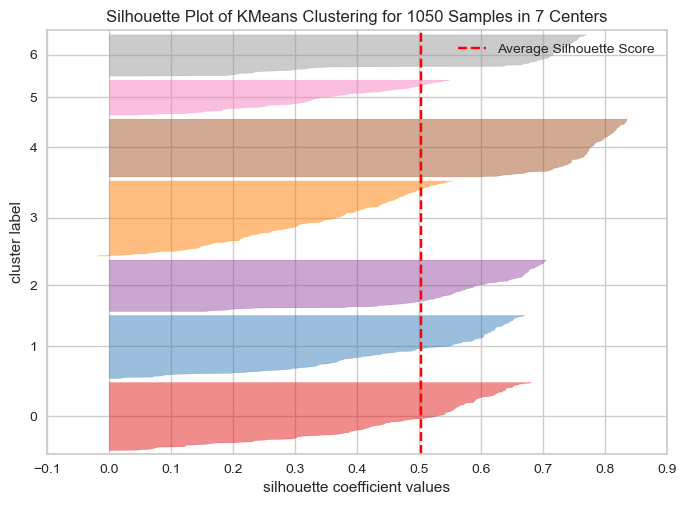

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 1050 Samples in 7 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [288]:
kmeans = KMeans(n_clusters=7, init="k-means++", random_state=0, n_init="auto")
visualizer = SilhouetteVisualizer(kmeans)

visualizer.fit(X_embedded)  # Fit the data to the visualizer
visualizer.poof()  # Draw/show/poof the data

In [289]:
df["kmeans_label"] = kmeans.labels_.astype(str)

In [290]:
ari_score = adjusted_rand_score(df["category0"], kmeans.labels_)

In [291]:
print(ari_score)

0.5753743292475884


In [292]:

show_scatter_graph(
    x=X_embedded[:,0],
    y=X_embedded[:,1],
    colors=df["kmeans_label"],
    title="Projection tSNE de X-PCA (200 composants) avec USE sur cleaned_product_name <br>avec partitionnement Kmeans"
)

In [293]:
show_scatter_graph(
    x=X_embedded[:,0],
    y=X_embedded[:,1],
    colors=df["category0"],
    title="Projection tSNE de X-PCA (200 composants) avec USE sur cleaned_product_name <br>avec catégorie de produit"
)

In [294]:
pd.crosstab(df["category0"], df["kmeans_label"])

kmeans_label,0,1,2,3,4,5,6
category0,,,,,,,
baby care,6,20,1,3,0,21,99
beauty and personal care,137,3,0,1,2,6,1
computers,2,0,120,3,0,25,0
home decor & festive needs,5,7,10,110,3,11,4
home furnishing,0,126,0,4,0,20,0
kitchen & dining,32,13,7,80,0,11,7
watches,0,0,0,0,150,0,0


En regardant les classes kmeans_labels majoritaires, on voit les correspondances:

|classe kmeans|classe réelle majoritaire|
|--------------|-------------|
|0|beauty and personal care|
|1|home furnishing|
|2|computers|
|3|home decor & festive needs |
|4|kitchen & dining|
|5|watches|
|6|baby care|  

In [295]:
df_cross = pd.crosstab(df["category0"], df["kmeans_label"])

In [296]:
# Obtenir le nom de la colonne avec la valeur maximale pour chaque ligne
max_columns = pd.crosstab(df["category0"], df["kmeans_label"]).idxmax(axis=1).tolist()

print(max_columns)


['6', '0', '2', '3', '1', '3', '4']


In [297]:
# Pour chaque colonne, obtenir l'index ayant la valeur maximale
max_indexes = [df_cross[col].idxmax() for col in df_cross.columns]

print(max_indexes)

['beauty and personal care', 'home furnishing', 'computers', 'home decor & festive needs', 'watches', 'computers', 'baby care']


"La fonction parcourt chaque colonne du dataframe, identifie l'index associé à la valeur maximale, et l'ajoute à une liste. Si cet index a déjà été choisi lors de l'analyse d'une colonne précédente, la fonction sélectionne l'index de la deuxième plus grande valeur. Cette approche est particulièrement utile lorsqu'on souhaite identifier des zones où l'algorithme a potentiellement mal classé ou prédit les données, en mettant en avant les cas où un certain index est fréquemment choisi comme le plus important."

In [298]:
# Initialiser une liste pour stocker les indexs
max_indexes2 = []

# Boucle pour obtenir l'index du max (ou du deuxième max si le premier est déjà pris)
for col in df_cross.columns:
    # Trier la colonne dans l'ordre décroissant
    sorted_col = df_cross[col].sort_values(ascending=False)
    
    # Si le premier élément (max) n'est pas déjà dans la liste, l'ajouter
    if sorted_col.index[0] not in max_indexes2:
        max_indexes2.append(sorted_col.index[0])
    # Sinon, ajouter le deuxième élément
    else:
        max_indexes2.append(sorted_col.index[1])

print(max_indexes2)

['beauty and personal care', 'home furnishing', 'computers', 'home decor & festive needs', 'watches', 'baby care', 'kitchen & dining']


In [299]:
from matplotlib import rc

rc('text', usetex=False)
rc('font', **{'family': 'serif', 'serif': ['cmr10']})


<Axes: ylabel='category0'>

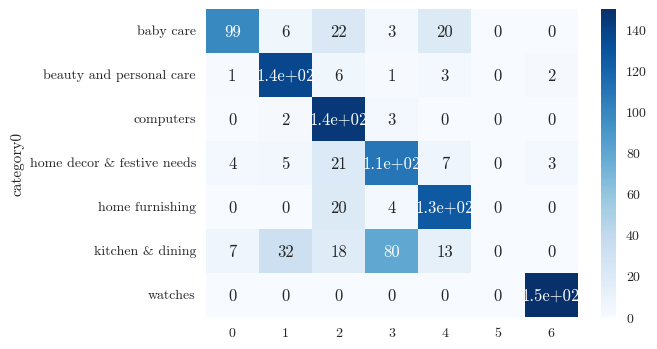

In [300]:
df["category_pred"] = ""

# corr_labels = [
#     "beauty and personal care",
#     "home furnishing",
#     "computers",
#     "home decor & festive needs",
#     "kitchen & dining",
#     "watches",
#     "baby care",
# ]

corr_labels = max_indexes

for i in range(0, len(corr_labels)):
    df.loc[df["kmeans_label"]==f"{i}", "category_pred"] = corr_labels[i]


conf_mat = confusion_matrix(df["category0"], df["category_pred"])

df_cm = pd.DataFrame(conf_mat, index = pd.crosstab(df["category0"], df["kmeans_label"]).reset_index()["category0"],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

In [301]:
print(classification_report(df["category0"], df["category_pred"]))

                            precision    recall  f1-score   support

                 baby care       0.89      0.66      0.76       150
  beauty and personal care       0.75      0.91      0.83       150
                 computers       0.62      0.97      0.76       150
home decor & festive needs       0.55      0.73      0.63       150
           home furnishing       0.75      0.84      0.79       150
          kitchen & dining       0.00      0.00      0.00       150
                   watches       0.97      1.00      0.98       150

                  accuracy                           0.73      1050
                 macro avg       0.65      0.73      0.68      1050
              weighted avg       0.65      0.73      0.68      1050



C:\Users\pouri\anaconda3\envs\mon_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\pouri\anaconda3\envs\mon_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\pouri\anaconda3\envs\mon_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Avec la classification à partir du plongement USE / cleaned_product_name / PCA-200 + tSNE, nous obtenons des résultats tout à fait acceptables.

L'utilisation de l'algorithme USE auquel on ajouterait une couche de décision est à envisager pour obtenir un classifieur à partir du texte fourni. On peut aussi envisager un classifieur du genre SVM et comparer les résultats.